**0 for the loan was repaid on time, or a 1 indicating the client had payment difficulties**

# imports

In [ ]:
%%capture
#@markdown

!pip install fairlearn

In [ ]:
%%capture
#@markdown
!pip install shap==0.43.0

In [ ]:
from __future__ import print_function
import shap
import sklearn
import sklearn.ensemble
import sklearn.metrics
shap.initjs()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from fairlearn.metrics import MetricFrame
from fairlearn.metrics import demographic_parity_difference, demographic_parity_ratio, selection_rate
from fairlearn.metrics import false_negative_rate, false_positive_rate

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/My Drive/RDS project/coding"
os.chdir(path)

## Input feature analysis
For each input feature, describe its datatype, give information on missing values and on the value distribution. Show pairwise correlations between features if appropriate. Run any other reasonable profiling of the input that you find interesting and appropriate


In [ ]:
# Training data
app_train = pd.read_csv('application_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Test data features
app_test = pd.read_csv('application_test.csv')
print('Testing data shape: ', app_test.shape)
app_test.head()

Testing data shape:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#describe each feature's datatype
column_types = app_test.dtypes
print(column_types,'\n')
print(app_train.dtypes.value_counts()) #65 float, 41 int, 16 categorical

SK_ID_CURR                      int64
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
FLAG_OWN_REALTY                object
                               ...   
AMT_REQ_CREDIT_BUREAU_DAY     float64
AMT_REQ_CREDIT_BUREAU_WEEK    float64
AMT_REQ_CREDIT_BUREAU_MON     float64
AMT_REQ_CREDIT_BUREAU_QRT     float64
AMT_REQ_CREDIT_BUREAU_YEAR    float64
Length: 121, dtype: object 

float64    65
int64      41
object     16
Name: count, dtype: int64


Text(0.5, 1.0, 'TARGET distribution')

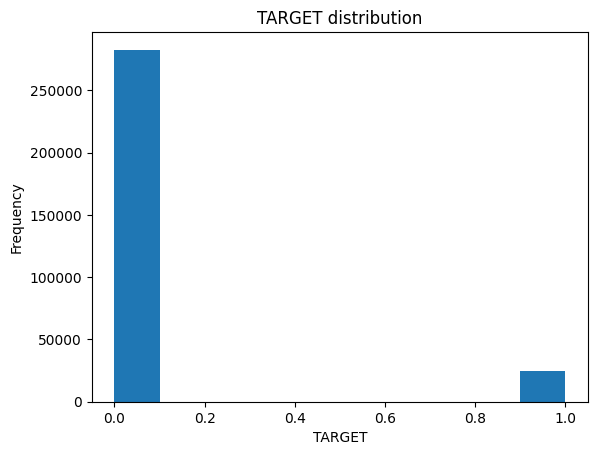

In [ ]:
# target value distribution
app_train['TARGET'].astype(int).plot.hist();
plt.xlabel('TARGET')
plt.title('TARGET distribution')

We can see a significant imbalance in the target values in the dataset.

In [ ]:
# print column names
app_test.columns.values.tolist()

['SK_ID_CURR',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEAR

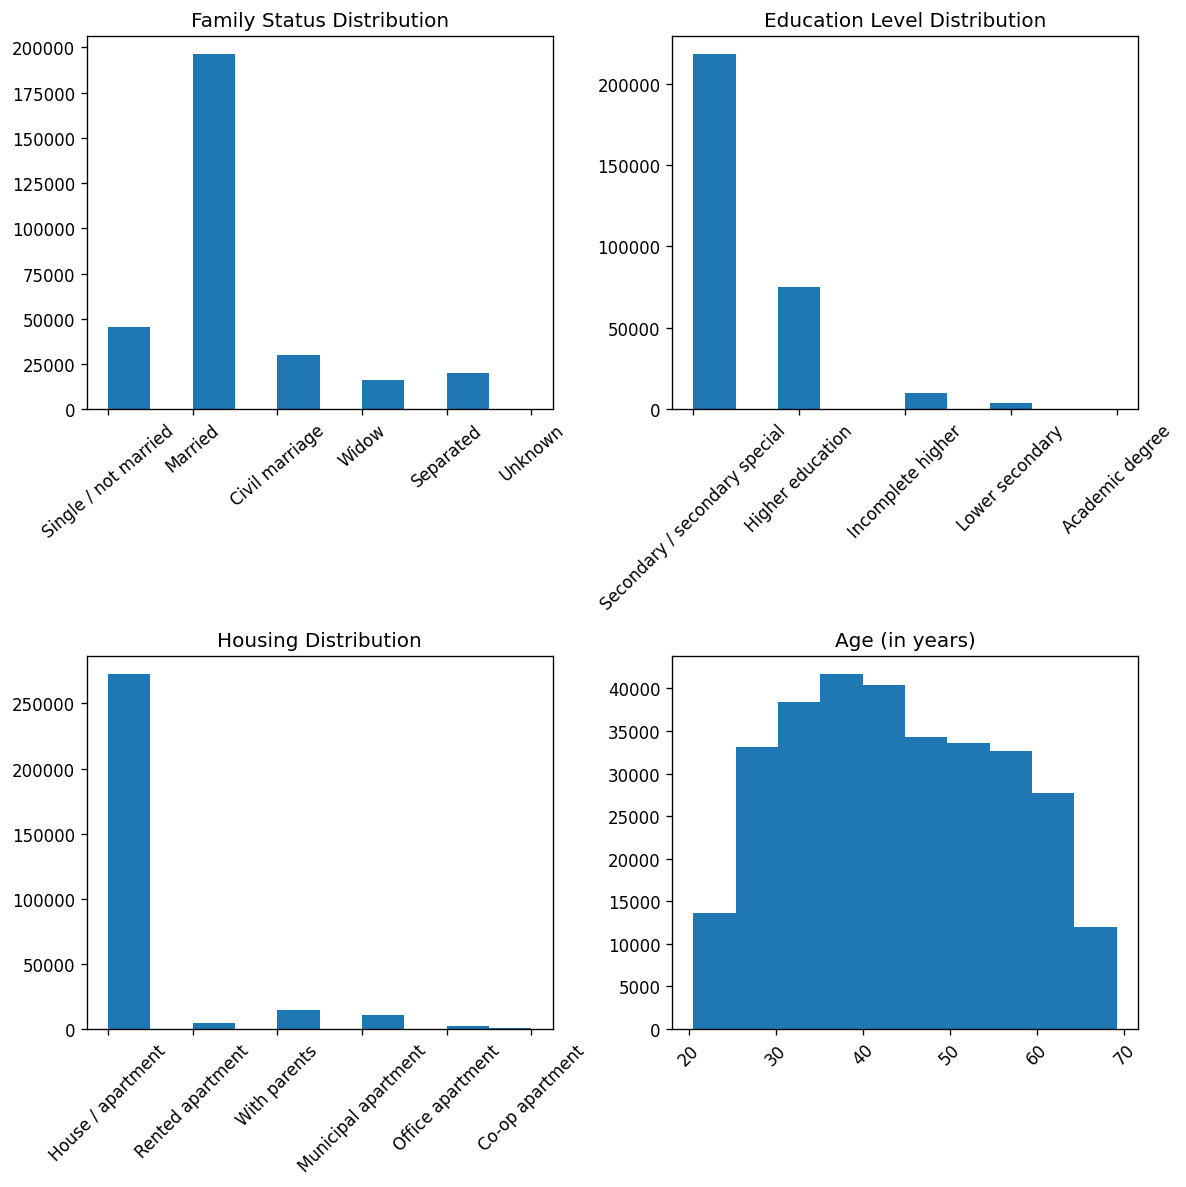

In [ ]:
#some categorical variables
fig, axes = plt.subplots(2, 2, figsize=(10,10), dpi=120)
axes[0][0].hist(app_train['NAME_FAMILY_STATUS'])
axes[0][0].set_title('Family Status Distribution')
axes[0][0].tick_params(axis='x', rotation=40)

axes[0][1].hist(app_train['NAME_EDUCATION_TYPE'])
axes[0][1].set_title('Education Level Distribution')
axes[0][1].tick_params(axis='x', rotation=45)

axes[1][0].hist(app_train['NAME_HOUSING_TYPE'])
axes[1][0].set_title('Housing Distribution')
axes[1][0].tick_params(axis='x', rotation=45)

axes[1][1].hist(abs(app_train['DAYS_BIRTH']/365))
axes[1][1].set_title('Age (in years)')
axes[1][1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
app_train['OCCUPATION_TYPE'].value_counts()

OCCUPATION_TYPE
Laborers                 55186
Sales staff              32102
Core staff               27570
Managers                 21371
Drivers                  18603
High skill tech staff    11380
Accountants               9813
Medicine staff            8537
Security staff            6721
Cooking staff             5946
Cleaning staff            4653
Private service staff     2652
Low-skill Laborers        2093
Waiters/barmen staff      1348
Secretaries               1305
Realty agents              751
HR staff                   563
IT staff                   526
Name: count, dtype: int64

In [ ]:
pd.crosstab(app_train['NAME_EDUCATION_TYPE'], app_train['OCCUPATION_TYPE'])

OCCUPATION_TYPE,Accountants,Cleaning staff,Cooking staff,Core staff,Drivers,HR staff,High skill tech staff,IT staff,Laborers,Low-skill Laborers,Managers,Medicine staff,Private service staff,Realty agents,Sales staff,Secretaries,Security staff,Waiters/barmen staff
NAME_EDUCATION_TYPE,,,,,,,,,,,,,,,,,,
Academic degree,8,2,1,25,5,0,3,0,9,1,37,0,2,1,9,0,4,0
Higher education,5798,250,427,13313,2050,357,4655,341,6578,81,11499,999,519,227,5562,481,821,179
Incomplete higher,445,49,118,1466,491,36,585,52,1587,30,931,146,114,47,1468,96,156,94
Lower secondary,18,108,64,123,249,0,31,1,730,92,57,77,11,2,228,4,97,17
Secondary / secondary special,3544,4244,5336,12643,15808,170,6106,132,46282,1889,8847,7315,2006,474,24835,724,5643,1058


In [ ]:
#0 for the loan was repaid on time, or a 1 indicating the client had payment difficulties
pd.crosstab(app_train['TARGET'], app_train['OCCUPATION_TYPE'])

OCCUPATION_TYPE,Accountants,Cleaning staff,Cooking staff,Core staff,Drivers,HR staff,High skill tech staff,IT staff,Laborers,Low-skill Laborers,Managers,Medicine staff,Private service staff,Realty agents,Sales staff,Secretaries,Security staff,Waiters/barmen staff
TARGET,,,,,,,,,,,,,,,,,,
0,9339,4206,5325,25832,16496,527,10679,492,49348,1734,20043,7965,2477,692,29010,1213,5999,1196
1,474,447,621,1738,2107,36,701,34,5838,359,1328,572,175,59,3092,92,722,152


In [ ]:
pd.crosstab(app_train['TARGET'], app_train['NAME_FAMILY_STATUS'])

NAME_FAMILY_STATUS,Civil marriage,Married,Separated,Single / not married,Unknown,Widow
TARGET,,,,,,
0,26814,181582,18150,40987,2,15151
1,2961,14850,1620,4457,0,937


In [ ]:
pd.crosstab(app_train['TARGET'], app_train['NAME_EDUCATION_TYPE'])

NAME_EDUCATION_TYPE,Academic degree,Higher education,Incomplete higher,Lower secondary,Secondary / secondary special
TARGET,,,,,
0,161,70854,9405,3399,198867
1,3,4009,872,417,19524


In [ ]:
np.sum(app_train.isna(), axis=0)  #total NaN in each col
app_train.loc[:, np.sum(app_train.isna(), axis=0) > 0] #shows 67 out of 121 columns (excluding target) has NaN values

,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,OWN_CAR_AGE,OCCUPATION_TYPE,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,...,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,24700.5,351000.0,Unaccompanied,NaN,Laborers,1.0,0.083037,0.262949,0.139376,0.0247,...,2.0,2.0,2.0,-1134.0,0.0,0.0,0.0,0.0,0.0,1.0
1,35698.5,1129500.0,Family,NaN,Core staff,2.0,0.311267,0.622246,NaN,0.0959,...,0.0,1.0,0.0,-828.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6750.0,135000.0,Unaccompanied,26.0,Laborers,1.0,NaN,0.555912,0.729567,NaN,...,0.0,0.0,0.0,-815.0,0.0,0.0,0.0,0.0,0.0,0.0
3,29686.5,297000.0,Unaccompanied,NaN,Laborers,2.0,NaN,0.650442,NaN,NaN,...,0.0,2.0,0.0,-617.0,NaN,NaN,NaN,NaN,NaN,NaN
4,21865.5,513000.0,Unaccompanied,NaN,Core staff,1.0,NaN,0.322738,NaN,NaN,...,0.0,0.0,0.0,-1106.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,27558.0,225000.0,Unaccompanied,NaN,Sales staff,1.0,0.145570,0.681632,NaN,0.2021,...,0.0,0.0,0.0,-273.0,NaN,NaN,NaN,NaN,NaN,NaN
307507,12001.5,225000.0,Unaccompanied,NaN,NaN,1.0,NaN,0.115992,NaN,0.0247,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
307508,29979.0,585000.0,Unaccompanied,NaN,Managers,1.0,0.744026,0.535722,0.218859,0.1031,...,0.0,6.0,0.0,-1909.0,1.0,0.0,0.0,1.0,0.0,1.0
307509,20205.0,319500.0,Unaccompanied,NaN,Laborers,2.0,NaN,0.514163,0.661024,0.0124,...,0.0,0.0,0.0,-322.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
app_train['TARGET'].describe()

count    307511.000000
mean          0.080729
std           0.272419
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: TARGET, dtype: float64

(array([282686.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  24825.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

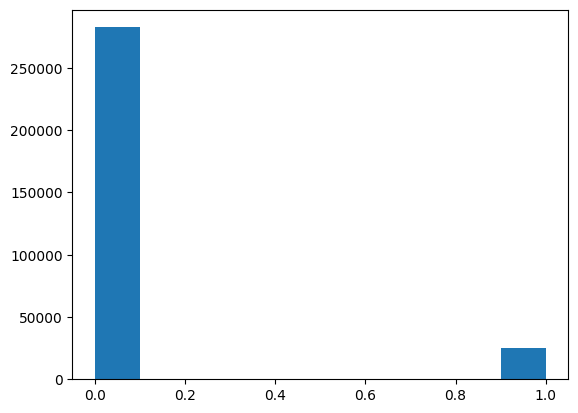

In [ ]:
plt.hist(app_train['TARGET'])

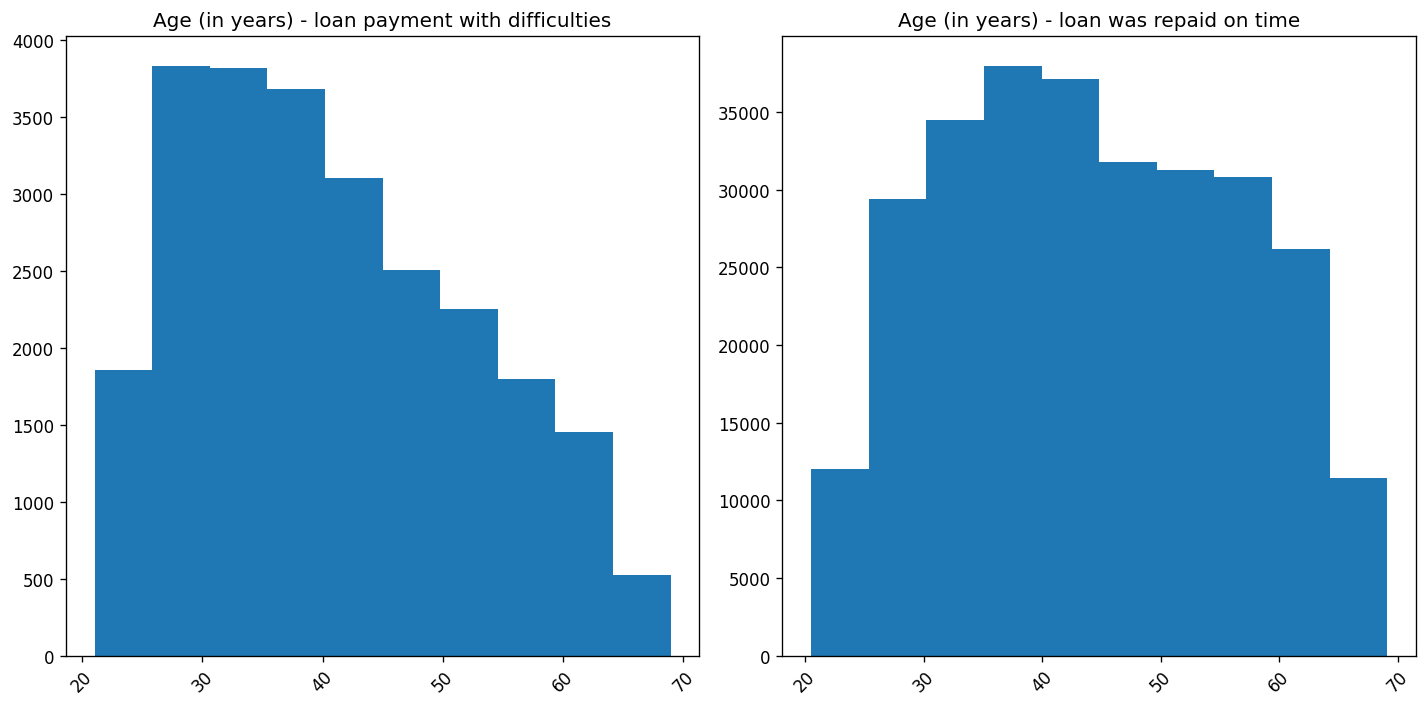

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12,6), dpi=120)

axes[0].hist(abs((app_train[app_train['TARGET'] == 1]['DAYS_BIRTH'])/365))
axes[0].set_title('Age (in years) - loan payment with difficulties')
axes[0].tick_params(axis='x', rotation=45)

axes[1].hist(abs((app_train[app_train['TARGET'] == 0]['DAYS_BIRTH'])/365))
axes[1].set_title('Age (in years) - loan was repaid on time')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

<Axes: xlabel='TARGET', ylabel='count'>

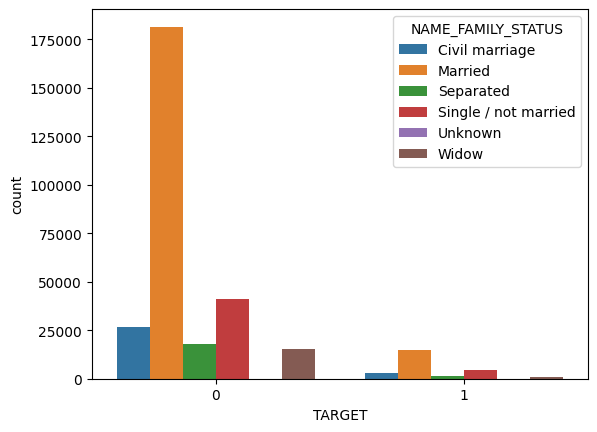

In [ ]:
temp = app_train.groupby(['NAME_FAMILY_STATUS', 'TARGET']).size().to_frame('count').reset_index()
sns.barplot(data=temp, x='TARGET', y='count', hue='NAME_FAMILY_STATUS')

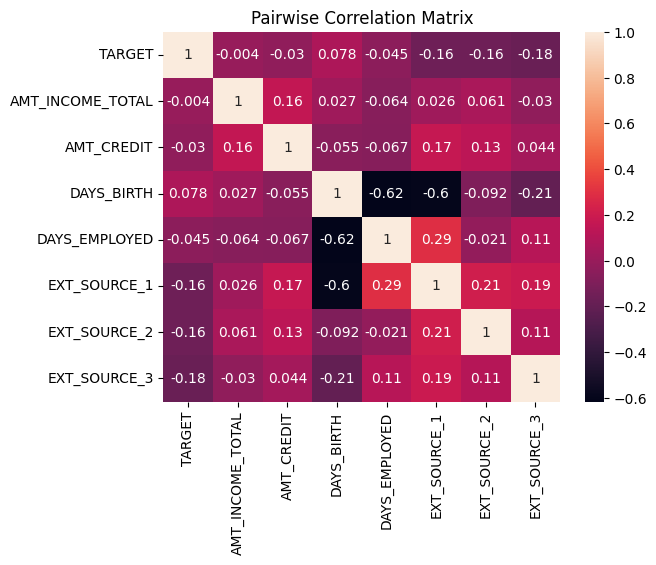

In [ ]:
# Compute the correlation matrix
feat_corr = (app_train[['TARGET', 'AMT_INCOME_TOTAL','AMT_CREDIT', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']]).corr()
sns.heatmap(feat_corr, annot=True)
plt.title('Pairwise Correlation Matrix')
plt.show()

### Label Encoding and One-Hot Encoding

Let's implement the policy described above: for any categorical variable (`dtype == object`) with 2 unique categories, we will use label encoding, and for any categorical variable with more than 2 unique categories, we will use one-hot encoding.

For label encoding, we use the Scikit-Learn `LabelEncoder` and for one-hot encoding, the pandas `get_dummies(df)` function.

In [ ]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])

            # Keep track of how many columns were label encoded
            le_count += 1

print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [ ]:
# one-hot encoding of categorical variables
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 239)


### Aligning Training and Testing Data

There need to be the same features (columns) in both the training and testing data. One-hot encoding has created more columns in the training data because there were some categorical variables with categories not represented in the testing data. To remove the columns in the training data that are not in the testing data, we need to `align` the dataframes. First we extract the target column from the training data (because this is not in the testing data but we need to keep this information). When we do the align, we must make sure to set `axis = 1` to align the dataframes based on the columns and not on the rows!

In [ ]:
train_labels = app_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Add the target back in
app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)


The training and testing datasets now have the same features which is required for machine learning. The number of features has grown significantly due to one-hot encoding. At some point we probably will want to try [dimensionality reduction (removing features that are not relevant)](https://en.wikipedia.org/wiki/Dimensionality_reduction) to reduce the size of the datasets.

In [ ]:
app_test.columns.values.tolist()

['SK_ID_CURR',
 'NAME_CONTRACT_TYPE',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NON

### Missing Values Assesment

In [ ]:
# Function to calculate missing values by column# Funct
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()

        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)

        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})

        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")

        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [ ]:
# Missing values statistics
missing_values = missing_values_table(app_train)
missing_values.head(20)

Your selected dataframe has 240 columns.
There are 61 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MODE,214865,69.9
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
NONLIVINGAPARTMENTS_MEDI,213514,69.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
FLOORSMIN_MEDI,208642,67.8


In [ ]:
# Missing values statistics by gender
app_train_f = app_train[app_train['CODE_GENDER_F'] == True]
app_train_m = app_train[app_train['CODE_GENDER_F'] == False]

missing_values_f = missing_values_table(app_train_f)
missing_values_f.rename(columns={'Female % of Total Values': 'Female % of Total Values'}, inplace=True)
missing_values_m = missing_values_table(app_train_m)
missing_values_m.rename(columns={'Male % of Total Values': 'Male % of Total Values'}, inplace=True)

Your selected dataframe has 240 columns.
There are 60 columns that have missing values.
Your selected dataframe has 240 columns.
There are 61 columns that have missing values.


In [ ]:
merged_missing_values_sex = pd.merge(missing_values_f, missing_values_m, left_index=True, right_index=True)
print('Female Average % of Missing Values for Women: ', merged_missing_values_sex['Female % of Total Values'].mean())
print('Male Average % of Missing Values for Men: ', merged_missing_values_sex['Male % of Total Values'].mean())
merged_missing_values_sex.head(10)

Female Average % of Missing Values for Women:  45.00333333333333
Male Average % of Missing Values for Men:  46.35166666666667


,Missing Values_x,Female % of Total Values,Missing Values_y,Male % of Total Values
OWN_CAR_AGE,157492,77.8,45437,43.2
COMMONAREA_MODE,140410,69.4,74455,70.9
COMMONAREA_MEDI,140410,69.4,74455,70.9
COMMONAREA_AVG,140410,69.4,74455,70.9
NONLIVINGAPARTMENTS_MODE,139521,68.9,73993,70.4
NONLIVINGAPARTMENTS_AVG,139521,68.9,73993,70.4
NONLIVINGAPARTMENTS_MEDI,139521,68.9,73993,70.4
LIVINGAPARTMENTS_AVG,137267,67.8,72932,69.4
LIVINGAPARTMENTS_MEDI,137267,67.8,72932,69.4
LIVINGAPARTMENTS_MODE,137267,67.8,72932,69.4


In [ ]:
# variables by which missing values differ by gender by more than 3%
merged_missing_values_sex[abs(merged_missing_values_sex['Female % of Total Values'] - merged_missing_values_sex['Male % of Total Values']) >= 3]

,Missing Values_x,Female % of Total Values,Missing Values_y,Male % of Total Values
OWN_CAR_AGE,157492,77.8,45437,43.2
EXT_SOURCE_1,110808,54.7,62570,59.6
TOTALAREA_MODE,95598,47.2,52833,50.3


In [ ]:
# Missing values statistics by age
app_train_y = app_train[abs(app_train['DAYS_BIRTH']/365) < 50]
app_train_o = app_train[abs(app_train['DAYS_BIRTH']/365) >= 50]

missing_values_y = missing_values_table(app_train_y)
missing_values_y.rename(columns={'% of Total Values': 'Under 50 % of Total Values'}, inplace=True)
missing_values_o = missing_values_table(app_train_o)
missing_values_o.rename(columns={'% of Total Values': 'Over 50 % of Total Values'}, inplace=True)

Your selected dataframe has 240 columns.
There are 61 columns that have missing values.
Your selected dataframe has 240 columns.
There are 59 columns that have missing values.


In [ ]:
merged_missing_values_age = pd.merge(missing_values_y, missing_values_o, left_index=True, right_index=True)
print('Under 50 Average % of Missing Values for Women: ', merged_missing_values_age['Under 50 % of Total Values'].mean())
print('Over 50 Average % of Missing Values for Men: ', merged_missing_values_age['Over 50 % of Total Values'].mean())
merged_missing_values_age.head(10)

Under 50 Average % of Missing Values for Women:  46.33728813559322
Over 50 Average % of Missing Values for Men:  45.99322033898306


,Missing Values_x,Under 50 % of Total Values,Missing Values_y,Over 50 % of Total Values
COMMONAREA_MODE,143179,70.2,71686,69.1
COMMONAREA_MEDI,143179,70.2,71686,69.1
COMMONAREA_AVG,143179,70.2,71686,69.1
NONLIVINGAPARTMENTS_MODE,142262,69.8,71252,68.7
NONLIVINGAPARTMENTS_AVG,142262,69.8,71252,68.7
NONLIVINGAPARTMENTS_MEDI,142262,69.8,71252,68.7
LIVINGAPARTMENTS_MEDI,140087,68.7,70112,67.6
LIVINGAPARTMENTS_AVG,140087,68.7,70112,67.6
LIVINGAPARTMENTS_MODE,140087,68.7,70112,67.6
FLOORSMIN_MEDI,139080,68.2,69562,67.1


In [ ]:
# variables by which missing values differ by age by more than 3%
merged_missing_values_age[abs(merged_missing_values_age['Under 50 % of Total Values'] - merged_missing_values_age['Over 50 % of Total Values']) >= 3]

,Missing Values_x,Under 50 % of Total Values,Missing Values_y,Over 50 % of Total Values
OWN_CAR_AGE,125086,61.4,77843,75.1
EXT_SOURCE_1,97473,47.8,75905,73.2


# Analyze baseline model (logistic regression)

In [ ]:
#load the trained log regression model from solution code
with open('baseline_log_reg.pkl', 'rb') as file:
    log_model = pickle.load(file)

Baseline model score is 0.671 (reported in solution code)

In [ ]:
log_pred_df = pd.read_csv('log_reg_baseline.csv')
log_pred_df[log_pred_df['TARGET'] > 0.5]

,SK_ID_CURR,TARGET


In [ ]:
log_pred_df = pd.read_csv('log_reg_baseline.csv')
threshold = 0.5  # Define your threshold here
log_pred_df['PRED_LABEL'] = (log_pred_df['TARGET'] >= threshold).astype(int)
log_pred_df

,SK_ID_CURR,TARGET,PRED_LABEL
0,100001,0.078515,0
1,100005,0.137926,0
2,100013,0.082194,0
3,100028,0.080921,0
4,100038,0.132618,0
...,...,...,...
48739,456221,0.098639,0
48740,456222,0.095744,0
48741,456223,0.077225,0
48742,456224,0.082389,0


The submission does not go as far as to use the created regression model to classify by setitng a threshold. As we can see above a instinctively reasonable threshold of 0.5, a 50% probability of not repaying the loan, does not capture any predictions. So to analyze the treatment of this model on different subgroups, we have to analyze the distribution of probabilities continuously as opposed to just based on classification outcome.

However, as the test data provided by the competition does not include target labels in the test dataset, we can only gain some idea of how the accuracy of this model performs by splitting the labeled training set up into a training and test group again and use this to investigate the accuracy of this model on the subgroups of the data.

we don't have the true labels of the test set, can't directly test accuracy, but all predicted labels seem to be 0

In [ ]:
# split training set used in solution to train an auditable model
app_train_x_train, app_train_x_test, app_train_y_train, app_train_y_test = train_test_split(app_train.drop(columns = ['TARGET']), app_train['TARGET'], test_size=0.3, random_state=1)

In [ ]:
# Feature names
features = list(app_train_x_train.columns)

# Copy of the testing data
test = app_train_x_test.copy()

# Median imputation of missing values
imputer = SimpleImputer(strategy = 'median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(app_train_x_train)

# Transform both training and testing data
train = imputer.transform(app_train_x_train)
test = imputer.transform(app_train_x_test)

# Repeat with the scaler
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (215257, 239)
Testing data shape:  (92254, 239)


In [ ]:
# Make the model with the specified regularization parameter
log_reg = LogisticRegression(C = 0.0001)

# Train on the training data
log_reg.fit(train, app_train_y_train)

LogisticRegression(C=0.0001)

In [ ]:
# Make predictions
# Make sure to select the second column only
log_reg_pred = log_reg.predict_proba(test)[:, 1]

In [ ]:
log_auc = roc_auc_score(app_train_y_test, log_reg_pred)
print(log_auc)

0.6860846102081825


The logistic regression was reported to have outputted an area under the ROC curve, the accuracy metric used in scoring this competition, of 0.671, which we can see is fairly similar to the AUC of 0.686 we got with our imitation model, suggesting our imitation model that we intend to examine further is not severely disabled by the limitation of some training data.  

##sex analysis

#### Comparing accuracy by gender

In [ ]:
# AUC for CODE_GENDER_F == True
x_test_gender_true = app_train_x_test[app_train_x_test['CODE_GENDER_F'] == True]
y_test_gender_true = app_train_y_test[app_train_x_test['CODE_GENDER_F'] == True]
log_reg_pred_gender_true = log_reg_pred[app_train_x_test['CODE_GENDER_F'] == True]
auc_gender_true = roc_auc_score(y_test_gender_true, log_reg_pred_gender_true)
print("AUC for Women:", auc_gender_true)

# AUC for CODE_GENDER_M == True
x_test_gender_false = app_train_x_test[app_train_x_test['CODE_GENDER_M'] == True]
y_test_gender_false = app_train_y_test[app_train_x_test['CODE_GENDER_M'] == True]
log_reg_pred_gender_false = log_reg_pred[app_train_x_test['CODE_GENDER_M'] == True]
auc_gender_false = roc_auc_score(y_test_gender_false, log_reg_pred_gender_false)
print("AUC for Men:", auc_gender_false)

AUC for Women: 0.6826884855278077
AUC for Men: 0.6734327599247025


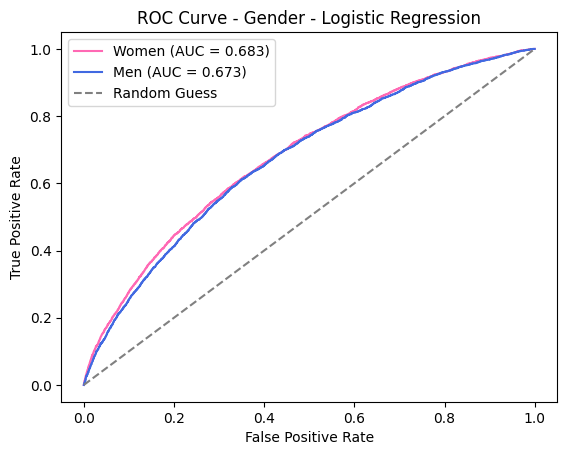

In [ ]:
fpr_f, tpr_f, _ = roc_curve(y_test_gender_true, log_reg_pred_gender_true)
fpr_m, tpr_m, _ = roc_curve(y_test_gender_false, log_reg_pred_gender_false)

# plot ROC curves
plt.plot(fpr_f, tpr_f, color='hotpink', label='Women (AUC = {:.3f})'.format(auc_gender_true))
plt.plot(fpr_m, tpr_m, color='royalblue', label='Men (AUC = {:.3f})'.format(auc_gender_false))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Gender - Logistic Regression')
plt.legend()
plt.show()

In [ ]:
errs_f = y_test_gender_true - log_reg_pred_gender_true
errs_m = y_test_gender_false - log_reg_pred_gender_false

mean_err_f = errs_f.mean()
mean_err_m = errs_m.mean()

print("Mean Error for Females:", mean_err_f)
print("Mean Error for Males:", mean_err_m)

Mean Error for Females: -0.0057972811753663036
Mean Error for Males: 0.01204918686932306


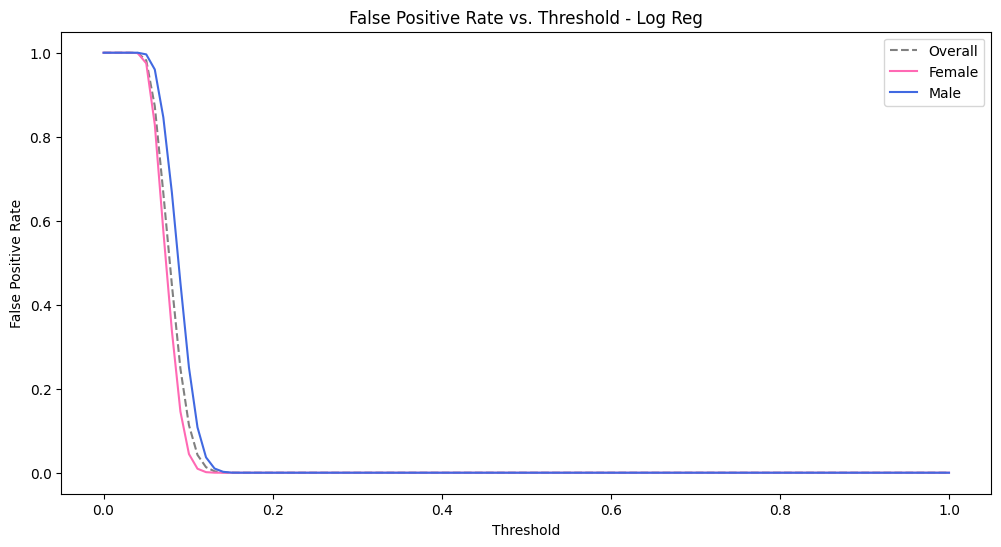

In [ ]:
# comparing FPR by sex
thresholds = np.linspace(0, 1, 100)
fprs_overall = []
fprs_female = []
fprs_male = []

for threshold in thresholds:
    y_pred = log_reg_pred > threshold
    conf_matrix = confusion_matrix(app_train_y_test, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    fpr_overall = fp / (fp + tn)
    fprs_overall.append(fpr_overall)

    subgroup_indices_female = app_train_x_test['CODE_GENDER_F'] == True
    subgroup_indices_male = app_train_x_test['CODE_GENDER_F'] == False

    conf_matrix_female = confusion_matrix(app_train_y_test[subgroup_indices_female], y_pred[subgroup_indices_female])
    tn_female, fp_female, fn_female, tp_female = conf_matrix_female.ravel()
    fpr_female = fp_female / (fp_female + tn_female)
    fprs_female.append(fpr_female)

    conf_matrix_male = confusion_matrix(app_train_y_test[subgroup_indices_male], y_pred[subgroup_indices_male])
    tn_male, fp_male, fn_male, tp_male = conf_matrix_male.ravel()
    fpr_male = fp_male / (fp_male + tn_male)
    fprs_male.append(fpr_male)

# fpr vs. threshold values
plt.figure(figsize=(12, 6))
plt.plot(thresholds, fprs_overall, label='Overall', color='grey', linestyle='--')
plt.plot(thresholds, fprs_female, label='Female', color='hotpink', linestyle='-')
plt.plot(thresholds, fprs_male, label='Male', color='royalblue', linestyle='-')

plt.xlabel('Threshold')
plt.ylabel('False Positive Rate')
plt.title('False Positive Rate vs. Threshold - Log Reg')
plt.legend()
plt.show()

Despite not having a given threshold by the solution, we can see by going through 100 possible values for the threshold from zero to one that using this logistic regression model, the fpr is always lower for women than it is for men (when they arent equal no or all false positives). This might present a cause for concern in that men are seemingly more likely, by this model to be classified as unreliable for a loan incorrectly than women.

#### demographic parity, selection rate sex

In [ ]:
#compute demographic parity difference and demographic parity ratio for target=0, diff sex
cols = ['CODE_GENDER_F', 'CODE_GENDER_M']
sensitive_feats = app_train_x_test[cols]
negative_class_pred = 1 - log_reg_pred
demo_parity_diff = demographic_parity_difference(app_train_y_test, negative_class_pred, sensitive_features=sensitive_feats)
demo_parity_ratio = demographic_parity_ratio(app_train_y_test, negative_class_pred, sensitive_features=sensitive_feats)

print(f'Demographic parity difference: {demo_parity_diff:.4f}')
print(f'Demographic parity ratio: {demo_parity_ratio:.4f}')

sex_selection_rates = {}
for sex in cols:
  select_rate = selection_rate(app_train_y_test[app_train_x_test[sex]==True], negative_class_pred[app_train_x_test[sex]==True])
  sex_selection_rates[sex.split('_')[-1]] = round(select_rate, 4)
print('selection rates for each sex\n')
sex_selection_rates

Demographic parity difference: 0.0000
Demographic parity ratio: nan
selection rates for each sex



{'F': 0.0, 'M': 0.0}

In [ ]:
sex_lg_selection = pd.DataFrame(list(sex_selection_rates.items()), columns=['Sex', 'Selection Rate (Log Reg Baseline)'])
sex_lg_selection

,Sex,Selection Rate (Log Reg Baseline)
0,F,0.0
1,M,0.0


##family status analysis

####accuracy by family status

AUC for NAME_FAMILY_STATUS_Civil marriage : 0.6871569854371368
AUC for NAME_FAMILY_STATUS_Married : 0.6817580338614279
AUC for NAME_FAMILY_STATUS_Separated : 0.6907307966828572
AUC for NAME_FAMILY_STATUS_Single / not married : 0.6953887574464948
AUC for NAME_FAMILY_STATUS_Widow : 0.6152227578147824


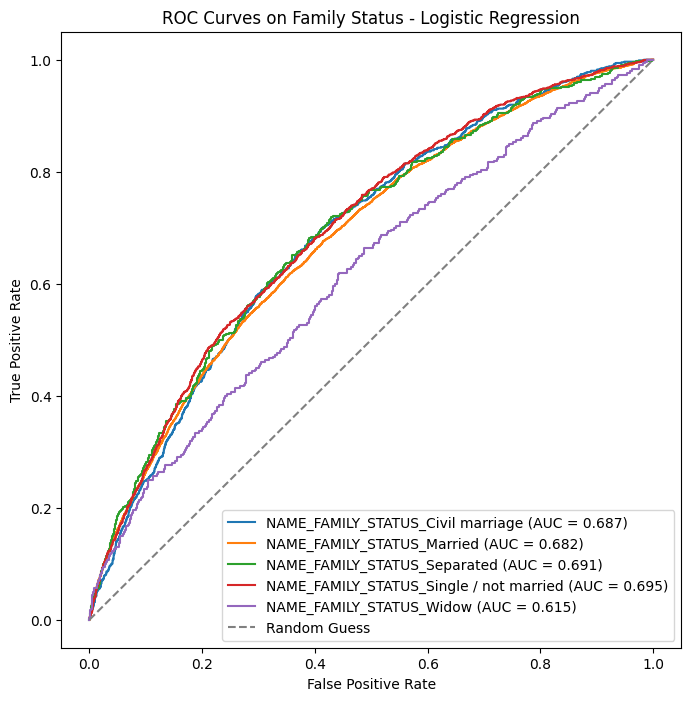

In [ ]:
cols = ['NAME_FAMILY_STATUS_Civil marriage', 'NAME_FAMILY_STATUS_Married',
                       'NAME_FAMILY_STATUS_Separated', 'NAME_FAMILY_STATUS_Single / not married',
                       'NAME_FAMILY_STATUS_Widow']
auc_scores = []
plt.figure(figsize=(8,8))
for column in cols:
    x_test_subgroup = app_train_x_test[app_train_x_test[column] == True]
    y_test_subgroup = app_train_y_test[app_train_x_test[column] == True]
    log_reg_pred_subgroup = log_reg_pred[app_train_x_test[column] == True]

    # AUC
    auc_subgroup = roc_auc_score(y_test_subgroup, log_reg_pred_subgroup)
    auc_scores.append(auc_subgroup)
    print("AUC for", column, ":", auc_subgroup)

    # ROC
    fpr, tpr, _ = roc_curve(y_test_subgroup, log_reg_pred_subgroup)
    plt.plot(fpr, tpr, label=f'{column} (AUC = {auc_subgroup:.3f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves on Family Status - Logistic Regression')
plt.legend()
plt.show()

#### demographic parity, selection rate fam status

In [ ]:
#compute demographic parity difference and demographic parity ratio for target=0, diff fam status
cols = ['NAME_FAMILY_STATUS_Civil marriage', 'NAME_FAMILY_STATUS_Married',
        'NAME_FAMILY_STATUS_Separated', 'NAME_FAMILY_STATUS_Single / not married',
        'NAME_FAMILY_STATUS_Widow']
sensitive_feats = app_train_x_test[cols]
negative_class_pred = 1 - log_reg_pred
demo_parity_diff = demographic_parity_difference(app_train_y_test, negative_class_pred, sensitive_features=sensitive_feats)
demo_parity_ratio = demographic_parity_ratio(app_train_y_test, negative_class_pred, sensitive_features=sensitive_feats)

print(f'Demographic parity difference: {demo_parity_diff:.4f}')
print(f'Demographic parity ratio: {demo_parity_ratio:.10f}')

fam_selection_rates = {}
for fam in cols:
  select_rate = selection_rate(app_train_y_test[app_train_x_test[fam]==True], negative_class_pred[app_train_x_test[fam]==True])
  fam_selection_rates[fam.split('_')[-1]] = round(select_rate, 4)
print('selection rates for each family status\n')
fam_selection_rates

Demographic parity difference: 0.0000
Demographic parity ratio: nan
selection rates for each family status



{'Civil marriage': 0.0,
 'Married': 0.0,
 'Separated': 0.0,
 'Single / not married': 0.0,
 'Widow': 0.0}

In [ ]:
fam_lg_selection = pd.DataFrame(list(fam_selection_rates.items()), columns=['Family Status', 'Selection Rate (Log Reg Baseline)'])
fam_lg_selection

,Family Status,Selection Rate (Log Reg Baseline)
0,Civil marriage,0.0
1,Married,0.0
2,Separated,0.0
3,Single / not married,0.0
4,Widow,0.0


##occupation analysis

#### accuracy by occupation

AUC for Accountants : 0.6921359113523292
AUC for Cleaning staff : 0.6563686368468119
AUC for Cooking staff : 0.6556802916906543
AUC for Core staff : 0.6956751943455746
AUC for Drivers : 0.6343502769236984
AUC for HR staff : 0.7549407114624507
AUC for High skill tech staff : 0.6612730716016917
AUC for IT staff : 0.7340277777777778
AUC for Laborers : 0.6796257647487353
AUC for Low-skill Laborers : 0.6033669692206277
AUC for Managers : 0.6971281134366097
AUC for Medicine staff : 0.6881690793565618
AUC for Private service staff : 0.6648097273097273
AUC for Realty agents : 0.693618881118881
AUC for Sales staff : 0.6582701402628734
AUC for Secretaries : 0.7222782258064516
AUC for Security staff : 0.6881066483094602


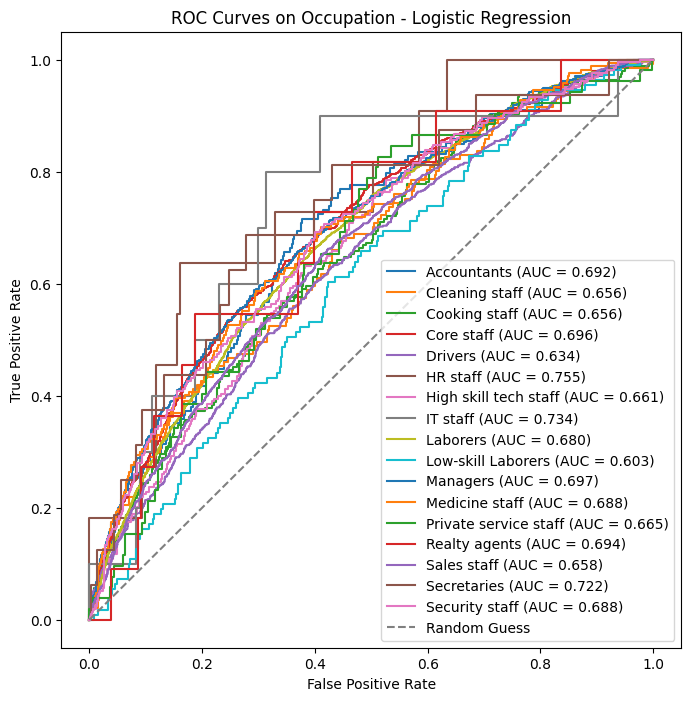

In [ ]:
cols = ['OCCUPATION_TYPE_Accountants', 'OCCUPATION_TYPE_Cleaning staff',
        'OCCUPATION_TYPE_Cooking staff', 'OCCUPATION_TYPE_Core staff',
        'OCCUPATION_TYPE_Drivers', 'OCCUPATION_TYPE_HR staff',
        'OCCUPATION_TYPE_High skill tech staff', 'OCCUPATION_TYPE_IT staff',
        'OCCUPATION_TYPE_Laborers', 'OCCUPATION_TYPE_Low-skill Laborers',
        'OCCUPATION_TYPE_Managers', 'OCCUPATION_TYPE_Medicine staff',
        'OCCUPATION_TYPE_Private service staff', 'OCCUPATION_TYPE_Realty agents',
        'OCCUPATION_TYPE_Sales staff', 'OCCUPATION_TYPE_Secretaries', 'OCCUPATION_TYPE_Security staff',]

auc_scores = []
plt.figure(figsize=(8,8))
for column in cols:
    name = column[16:]
    x_test_subgroup = app_train_x_test[app_train_x_test[column] == True]
    y_test_subgroup = app_train_y_test[app_train_x_test[column] == True]
    log_reg_pred_subgroup = log_reg_pred[app_train_x_test[column] == True]

    # AUC
    auc_subgroup = roc_auc_score(y_test_subgroup, log_reg_pred_subgroup)
    auc_scores.append(auc_subgroup)
    print("AUC for", name, ":", auc_subgroup)

    # ROC
    fpr, tpr, _ = roc_curve(y_test_subgroup, log_reg_pred_subgroup)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_subgroup:.3f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves on Occupation - Logistic Regression')
plt.legend()
plt.show()

In [ ]:
#compute demographic parity difference and demographic parity ratio for target=0, diff occupation
cols = ['OCCUPATION_TYPE_Accountants', 'OCCUPATION_TYPE_Cleaning staff',
        'OCCUPATION_TYPE_Cooking staff', 'OCCUPATION_TYPE_Core staff',
        'OCCUPATION_TYPE_Drivers', 'OCCUPATION_TYPE_HR staff',
        'OCCUPATION_TYPE_High skill tech staff', 'OCCUPATION_TYPE_IT staff',
        'OCCUPATION_TYPE_Laborers', 'OCCUPATION_TYPE_Low-skill Laborers',
        'OCCUPATION_TYPE_Managers', 'OCCUPATION_TYPE_Medicine staff',
        'OCCUPATION_TYPE_Private service staff', 'OCCUPATION_TYPE_Realty agents',
        'OCCUPATION_TYPE_Sales staff', 'OCCUPATION_TYPE_Secretaries', 'OCCUPATION_TYPE_Security staff']
sensitive_feats = app_train_x_test[cols]
negative_class_pred = 1 - log_reg_pred
demo_parity_diff = demographic_parity_difference(app_train_y_test, negative_class_pred, sensitive_features=sensitive_feats)
demo_parity_ratio = demographic_parity_ratio(app_train_y_test, negative_class_pred, sensitive_features=sensitive_feats)

print(f'Demographic parity difference: {demo_parity_diff:.4f}')
print(f'Demographic parity ratio: {demo_parity_ratio:.4f}')

job_selection_rates = {}
for occupation in cols:
  select_rate = selection_rate(app_train_y_test[app_train_x_test[occupation]==True], negative_class_pred[app_train_x_test[occupation]==True])
  job_selection_rates[occupation.split('_')[-1]] = round(select_rate, 4)
print('selection rates for each occupation\n')
job_selection_rates

Demographic parity difference: 0.0000
Demographic parity ratio: nan
selection rates for each occupation



{'Accountants': 0.0,
 'Cleaning staff': 0.0,
 'Cooking staff': 0.0,
 'Core staff': 0.0,
 'Drivers': 0.0,
 'HR staff': 0.0,
 'High skill tech staff': 0.0,
 'IT staff': 0.0,
 'Laborers': 0.0,
 'Low-skill Laborers': 0.0,
 'Managers': 0.0,
 'Medicine staff': 0.0,
 'Private service staff': 0.0,
 'Realty agents': 0.0,
 'Sales staff': 0.0,
 'Secretaries': 0.0,
 'Security staff': 0.0}

In [ ]:
job_lg_selection = pd.DataFrame(list(job_selection_rates.items()), columns=['Occupation Type', 'Selection Rate (Log Reg Baseline)'])
job_lg_selection

,Occupation Type,Selection Rate (Log Reg Baseline)
0,Accountants,0.0
1,Cleaning staff,0.0
2,Cooking staff,0.0
3,Core staff,0.0
4,Drivers,0.0
5,HR staff,0.0
6,High skill tech staff,0.0
7,IT staff,0.0
8,Laborers,0.0
9,Low-skill Laborers,0.0


In [ ]:
app_train['NAME_INCOME_TYPE_Businessman'][app_train['NAME_INCOME_TYPE_Businessman'] == True]

'NAME_INCOME_TYPE_Student',

29666     True
29737     True
87098     True
92166     True
133120    True
145707    True
213668    True
235450    True
254641    True
292267    True
Name: NAME_INCOME_TYPE_Businessman, dtype: bool

AUC for Commercial associate : 0.6954965467328278
AUC for Pensioner : 0.6610856615979042
AUC for State servant : 0.7083993930334884
AUC for Unemployed : 0.6666666666666667
AUC for Working : 0.6823306979850626


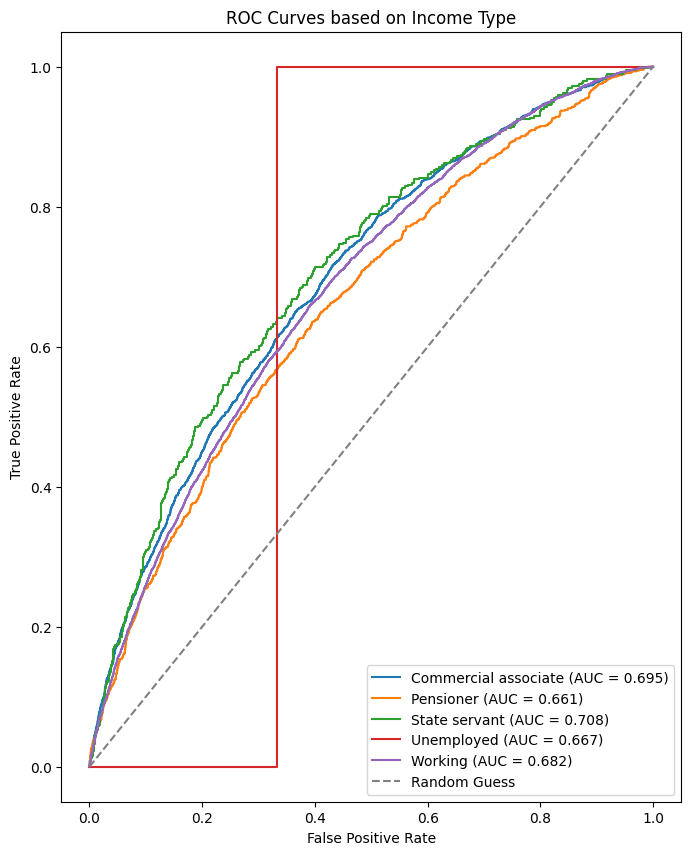

In [ ]:
cols = ['NAME_INCOME_TYPE_Commercial associate', 'NAME_INCOME_TYPE_Pensioner', 'NAME_INCOME_TYPE_State servant',
        'NAME_INCOME_TYPE_Unemployed', 'NAME_INCOME_TYPE_Working']

auc_scores = []
plt.figure(figsize=(8,10))
for column in cols:
    name = column[17:]
    x_test_subgroup = app_train_x_test[app_train_x_test[column] == True]
    y_test_subgroup = app_train_y_test[app_train_x_test[column] == True]
    log_reg_pred_subgroup = log_reg_pred[app_train_x_test[column] == True]

    # AUC
    auc_subgroup = roc_auc_score(y_test_subgroup, log_reg_pred_subgroup)
    auc_scores.append(auc_subgroup)
    print("AUC for", name, ":", auc_subgroup)

    # ROC
    fpr, tpr, _ = roc_curve(y_test_subgroup, log_reg_pred_subgroup)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_subgroup:.3f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves based on Income Type')
plt.legend()
plt.show()

AUC for Quantile 1 : 0.6778517495989962
AUC for Quantile 2 : 0.6787760497284417
AUC for Quantile 3 : 0.6887911004511797
AUC for Quantile 4 : 0.6956727657973674


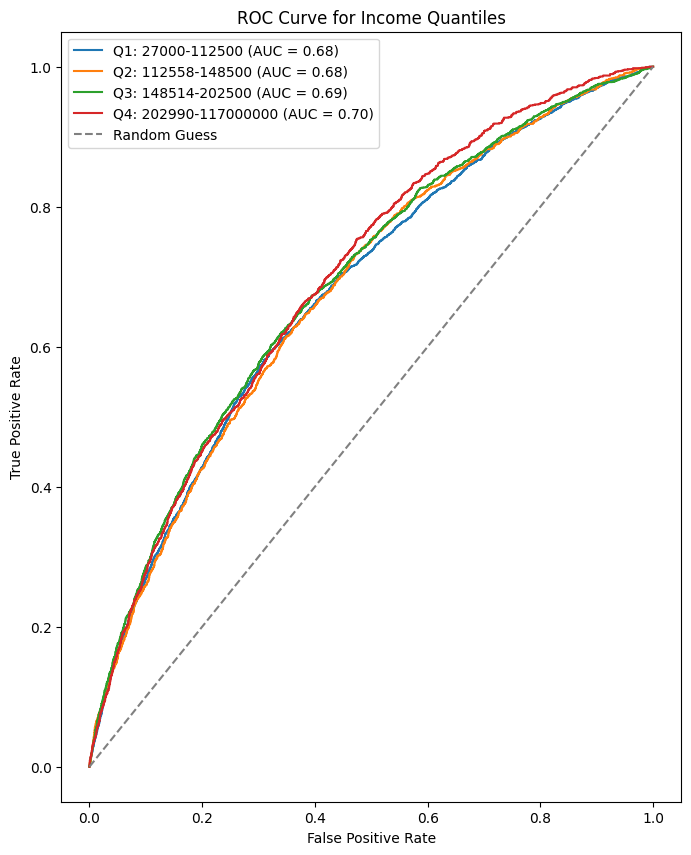

In [ ]:
# divide data into four quantiles of unique incomes
quantiles = pd.qcut(app_train_x_test['AMT_INCOME_TOTAL'], q=4, labels=False)

# calculate AUC and ROC curves for each quantile
auc_scores = []
plt.figure(figsize=(8,10))
for quantile in range(4):
    x_test_quantile = app_train_x_test[quantiles == quantile]
    y_test_quantile = app_train_y_test[quantiles == quantile]
    log_reg_pred_quantile = log_reg_pred[quantiles == quantile]

    income_min = min(x_test_quantile['AMT_INCOME_TOTAL'])
    income_max = max(x_test_quantile['AMT_INCOME_TOTAL'])

    # AUC
    auc_quantile = roc_auc_score(y_test_quantile, log_reg_pred_quantile)
    auc_scores.append(auc_quantile)
    print("AUC for Quantile", quantile + 1, ":", auc_quantile)

    # ROC
    fpr, tpr, _ = roc_curve(y_test_quantile, log_reg_pred_quantile)
    plt.plot(fpr, tpr, label=f'Q{quantile + 1}: {income_min:.0f}-{income_max:.0f} (AUC = {auc_quantile:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Income Quantiles - Logistic Regression')
plt.legend()
plt.show()

AUC for INCOME >= 60,000: 0.6868580219394294
AUC for INCOME < 60,000: 0.6527688316335659


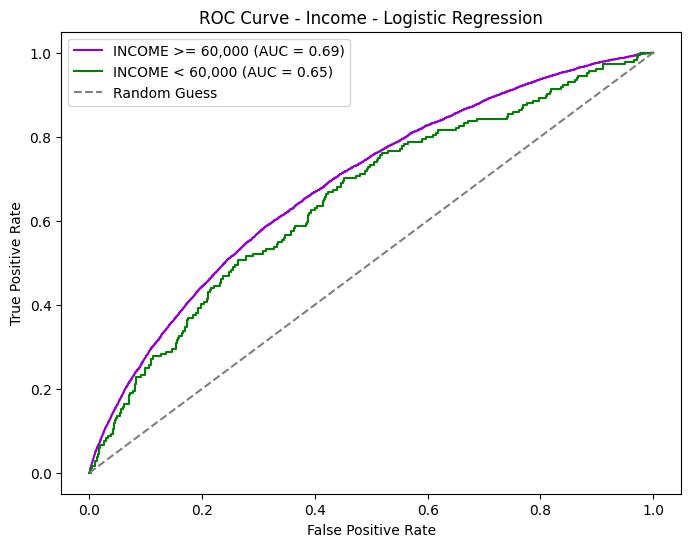

In [ ]:
# threshold for dividing income
threshold = 60000

# AUC for INCOME >= 50000
x_test_income_greater = app_train_x_test[app_train_x_test['AMT_INCOME_TOTAL'] >= threshold]
y_test_income_greater = app_train_y_test[app_train_x_test['AMT_INCOME_TOTAL'] >= threshold]
log_reg_pred_income_greater = log_reg_pred[app_train_x_test['AMT_INCOME_TOTAL'] >= threshold]
auc_income_greater = roc_auc_score(y_test_income_greater, log_reg_pred_income_greater)
print("AUC for INCOME >= 60,000:", auc_income_greater)

# AUC for INCOME < 50000
x_test_income_less = app_train_x_test[app_train_x_test['AMT_INCOME_TOTAL'] < threshold]
y_test_income_less = app_train_y_test[app_train_x_test['AMT_INCOME_TOTAL'] < threshold]
log_reg_pred_income_less = log_reg_pred[app_train_x_test['AMT_INCOME_TOTAL'] < threshold]
auc_income_less = roc_auc_score(y_test_income_less, log_reg_pred_income_less)
print("AUC for INCOME < 60,000:", auc_income_less)

fpr_income_greater, tpr_income_greater, _ = roc_curve(y_test_income_greater, log_reg_pred_income_greater)
fpr_income_less, tpr_income_less, _ = roc_curve(y_test_income_less, log_reg_pred_income_less)

# ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_income_greater, tpr_income_greater, color='darkviolet', label='INCOME >= 60,000 (AUC = {:.2f})'.format(auc_income_greater))
plt.plot(fpr_income_less, tpr_income_less, color='g', label='INCOME < 60,000 (AUC = {:.2f})'.format(auc_income_less))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Income - Logistic Regression')
plt.legend()
plt.show()

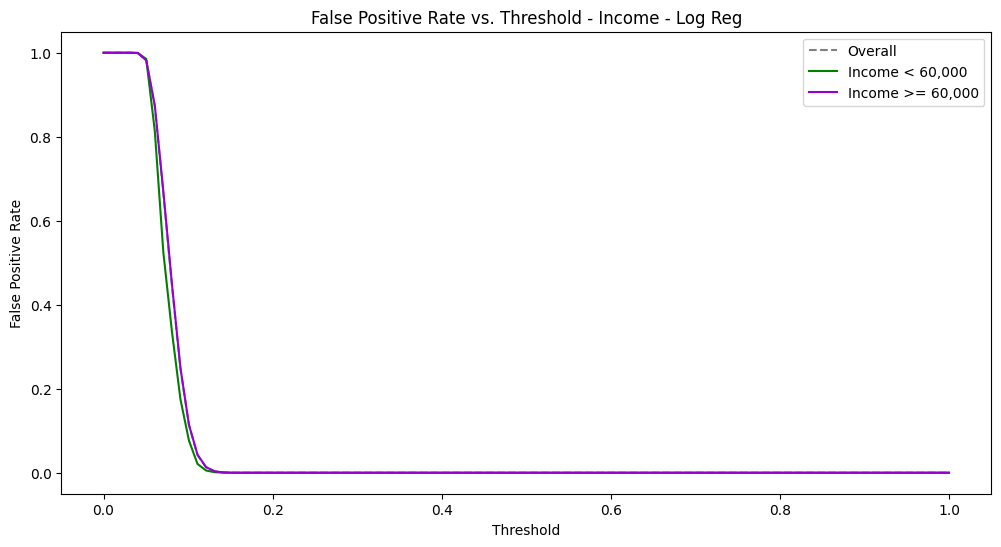

In [ ]:
# comparing FPR by income
thresholds = np.linspace(0, 1, 100)
log_fprs_overall = []
log_fprs_less = []
log_fprs_greater = []

for threshold in thresholds:
    y_pred = log_reg_pred > threshold
    conf_matrix = confusion_matrix(app_train_y_test, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    fpr_overall = fp / (fp + tn)
    log_fprs_overall.append(fpr_overall)

    subgroup_indices_less = app_train_x_test['AMT_INCOME_TOTAL'] < 60000
    subgroup_indices_greater = app_train_x_test['AMT_INCOME_TOTAL'] >= 60000

    conf_matrix_less = confusion_matrix(app_train_y_test[subgroup_indices_less], y_pred[subgroup_indices_less])
    tn_less, fp_less, fn_less, tp_less = conf_matrix_less.ravel()
    fpr_less = fp_less / (fp_less + tn_less)
    log_fprs_less.append(fpr_less)

    conf_matrix_greater = confusion_matrix(app_train_y_test[subgroup_indices_greater], y_pred[subgroup_indices_greater])
    tn_greater, fp_greater, fn_greater, tp_greater = conf_matrix_greater.ravel()
    fpr_greater = fp_greater / (fp_greater + tn_greater)
    log_fprs_greater.append(fpr_greater)

# fpr vs. threshold values
plt.figure(figsize=(12, 6))
plt.plot(thresholds, log_fprs_overall, label='Overall', color='grey', linestyle='--')
plt.plot(thresholds, log_fprs_less, label='Income < 60,000', color='g', linestyle='-')
plt.plot(thresholds, log_fprs_greater, label='Income >= 60,000', color='darkviolet', linestyle='-')

plt.xlabel('Threshold')
plt.ylabel('False Positive Rate')
plt.title('False Positive Rate vs. Threshold - Income - Log Reg')
plt.legend()
plt.show()

## age analysis

####accuracy by age

AUC for AGE >= 50: 0.6487050213595325
AUC for AGE < 50: 0.6838182750148228


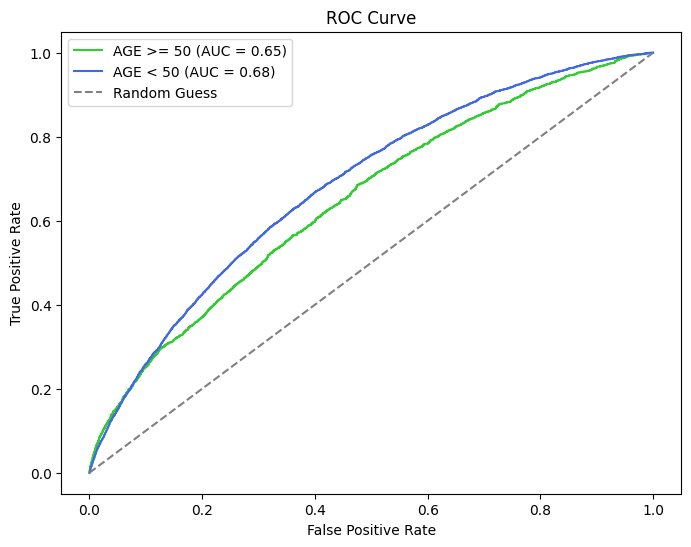

In [ ]:
app_train_x_test['AGE'] = np.abs(app_train_x_test['DAYS_BIRTH'] / 365)

# threshold for dividing age
threshold = 50

# AUC for AGE >= 50
x_test_age_greater_than_50 = app_train_x_test[app_train_x_test['AGE'] >= threshold]
y_test_age_greater_than_50 = app_train_y_test[app_train_x_test['AGE'] >= threshold]
log_reg_pred_age_greater_than_50 = log_reg_pred[app_train_x_test['AGE'] >= threshold]
auc_age_greater_than_50 = roc_auc_score(y_test_age_greater_than_50, log_reg_pred_age_greater_than_50)
print("AUC for AGE >= 50:", auc_age_greater_than_50)

# AUC for AGE < 50
x_test_age_less_than_50 = app_train_x_test[app_train_x_test['AGE'] < threshold]
y_test_age_less_than_50 = app_train_y_test[app_train_x_test['AGE'] < threshold]
log_reg_pred_age_less_than_50 = log_reg_pred[app_train_x_test['AGE'] < threshold]
auc_age_less_than_50 = roc_auc_score(y_test_age_less_than_50, log_reg_pred_age_less_than_50)
print("AUC for AGE < 50:", auc_age_less_than_50)

fpr_age_greater_than_50, tpr_age_greater_than_50, _ = roc_curve(y_test_age_greater_than_50, log_reg_pred_age_greater_than_50)
fpr_age_less_than_50, tpr_age_less_than_50, _ = roc_curve(y_test_age_less_than_50, log_reg_pred_age_less_than_50)

# ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_age_greater_than_50, tpr_age_greater_than_50, color='limegreen', label='AGE >= 50 (AUC = {:.2f})'.format(auc_age_greater_than_50))
plt.plot(fpr_age_less_than_50, tpr_age_less_than_50, color='royalblue', label='AGE < 50 (AUC = {:.2f})'.format(auc_age_less_than_50))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [ ]:
# mean error in predictions
errs_y = y_test_age_less_than_50 - log_reg_pred_age_less_than_50
errs_o = y_test_age_greater_than_50 - log_reg_pred_age_greater_than_50

mean_err_y = errs_y.mean()
mean_err_o = errs_o.mean()

print("Mean Error for Age < 50 :", mean_err_y)
print("Mean Error for Age >= 50:", mean_err_o)

Mean Error for Age < 50 : 0.007447727515245576
Mean Error for Age >= 50: -0.013859765589465809


AUC for Quantile 1 : 0.67041401964839
AUC for Quantile 2 : 0.6896531152798718
AUC for Quantile 3 : 0.6785884250241662
AUC for Quantile 4 : 0.6377128582250443


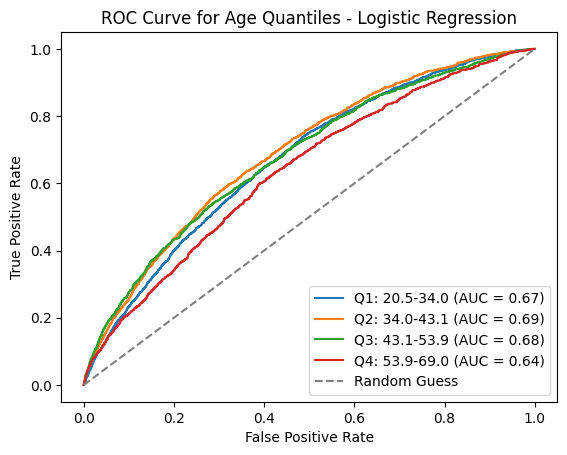

In [ ]:
# divide data into four quantiles of unique ages
app_train_x_test['AGE'] = np.abs(app_train_x_test['DAYS_BIRTH'] / 365)
quantiles = pd.qcut(app_train_x_test['AGE'], q=4, labels=False)

# calculate AUC and ROC curves for each quantile
auc_scores = []
for quantile in range(4):
    x_test_quantile = app_train_x_test[quantiles == quantile]
    y_test_quantile = app_train_y_test[quantiles == quantile]
    log_reg_pred_quantile = log_reg_pred[quantiles == quantile]

    age_min = min(x_test_quantile['AGE'])
    age_max = max(x_test_quantile['AGE'])

    # AUC
    auc_quantile = roc_auc_score(y_test_quantile, log_reg_pred_quantile)
    auc_scores.append(auc_quantile)
    print("AUC for Quantile", quantile + 1, ":", auc_quantile)

    # ROC
    fpr, tpr, _ = roc_curve(y_test_quantile, log_reg_pred_quantile)
    plt.plot(fpr, tpr, label=f'Q{quantile + 1}: {age_min:.1f}-{age_max:.1f} (AUC = {auc_quantile:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Age Quantiles - Logistic Regression')
plt.legend()
plt.show()

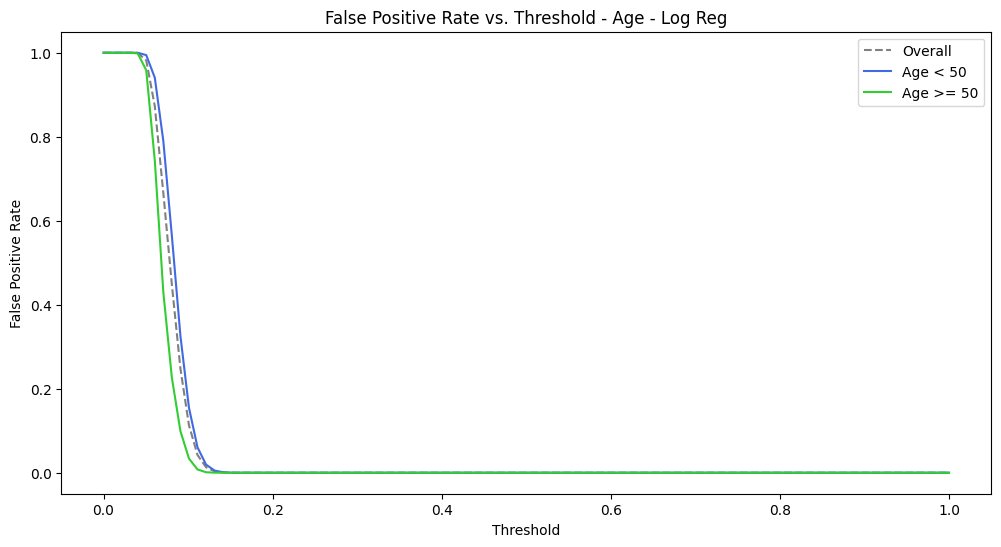

In [ ]:
# comparing FPR by age
thresholds = np.linspace(0, 1, 100)
log_fprs_overall = []
log_fprs_less = []
log_fprs_greater = []

for threshold in thresholds:
    y_pred = log_reg_pred > threshold
    conf_matrix = confusion_matrix(app_train_y_test, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    fpr_overall = fp / (fp + tn)
    log_fprs_overall.append(fpr_overall)

    subgroup_indices_less = app_train_x_test['AGE'] < 50
    subgroup_indices_greater = app_train_x_test['AGE'] >= 50

    conf_matrix_less = confusion_matrix(app_train_y_test[subgroup_indices_less], y_pred[subgroup_indices_less])
    tn_less, fp_less, fn_less, tp_less = conf_matrix_less.ravel()
    fpr_less = fp_less / (fp_less + tn_less)
    log_fprs_less.append(fpr_less)

    conf_matrix_greater = confusion_matrix(app_train_y_test[subgroup_indices_greater], y_pred[subgroup_indices_greater])
    tn_greater, fp_greater, fn_greater, tp_greater = conf_matrix_greater.ravel()
    fpr_greater = fp_greater / (fp_greater + tn_greater)
    log_fprs_greater.append(fpr_greater)

# fpr vs. threshold values
plt.figure(figsize=(12, 6))
plt.plot(thresholds, log_fprs_overall, label='Overall', color='grey', linestyle='--')
plt.plot(thresholds, log_fprs_less, label='Age < 50', color='royalblue', linestyle='-')
plt.plot(thresholds, log_fprs_greater, label='Age >= 50', color='limegreen', linestyle='-')

plt.xlabel('Threshold')
plt.ylabel('False Positive Rate')
plt.title('False Positive Rate vs. Threshold - Age - Log Reg')
plt.legend()
plt.show()

## overall?

since there's no true labels to the test set, it's hard to compare how well the model did. But despite that, the model predicted all labels to be 0, which doesn't seem useful. I think we care more about whether someone had issues repaying loans (class 1).

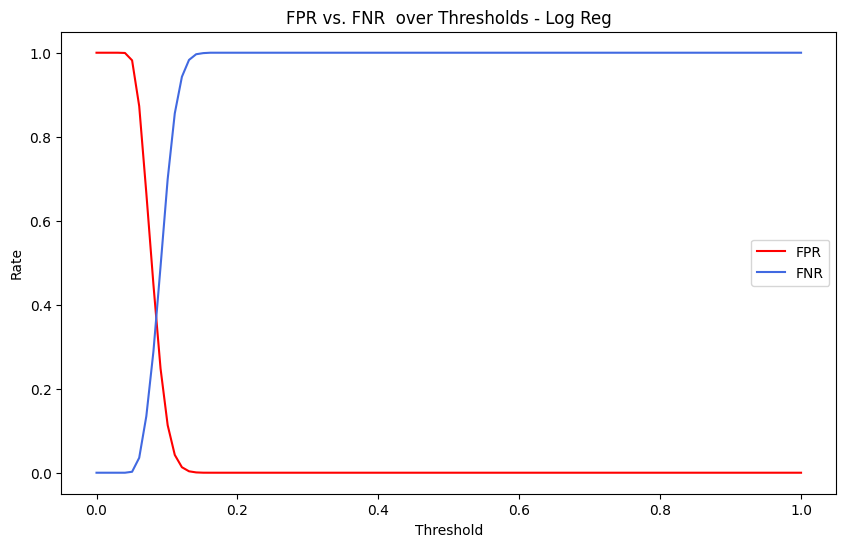

In [ ]:
thresholds = np.linspace(0, 1, 100)
fprs = []
fnrs = []

for threshold in thresholds:
    y_pred = log_reg_pred > threshold
    tn, fp, fn, tp = confusion_matrix(app_train_y_test, y_pred).ravel()
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)
    fprs.append(fpr)
    fnrs.append(fnr)

# fpr vs. fnr over threshold values
plt.figure(figsize=(10, 6))
plt.plot(thresholds, fprs, label='FPR', color='red', linestyle='-')
plt.plot(thresholds, fnrs, label='FNR', color='royalblue', linestyle='-')
plt.xlabel('Threshold')
plt.ylabel('Rate')
plt.title('FPR vs. FNR  over Thresholds - Log Reg')
plt.legend()
plt.show()

# Analyze random forest model

In [ ]:
with open('random_forest_model.pkl', 'rb') as file:
    rf_model = pickle.load(file)

In [ ]:
rf_model

RandomForestClassifier(n_jobs=-1, random_state=50, verbose=1)

In [ ]:
# Make the random forest classifier
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

In [ ]:
# Train on the training data
random_forest.fit(train, app_train_y_train)

# Extract feature importances
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

# Make predictions on the test data
predictions = random_forest.predict_proba(test)[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.9min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.6s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    3.7s finished


In [ ]:
rf_auc = roc_auc_score(app_train_y_test, predictions)
print(rf_auc)

0.7079329099223677


##sex analysis

###accuracy

In [ ]:
# AUC for CODE_GENDER_F == True
x_test_female = app_train_x_test[app_train_x_test['CODE_GENDER_F'] == True]
y_test_female = app_train_y_test[app_train_x_test['CODE_GENDER_F'] == True]
rf_pred_female = predictions[app_train_x_test['CODE_GENDER_F'] == True]
auc_female = roc_auc_score(y_test_female, rf_pred_female)
print("AUC for Women:", auc_female)

# AUC for CODE_GENDER_M == True
x_test_male = app_train_x_test[app_train_x_test['CODE_GENDER_M'] == True]
y_test_male = app_train_y_test[app_train_x_test['CODE_GENDER_M'] == True]
rf_pred_male = predictions[app_train_x_test['CODE_GENDER_M'] == True]
auc_male = roc_auc_score(y_test_male, rf_pred_male)
print("AUC for Men:", auc_male)

AUC for Women: 0.7018018300731658
AUC for Men: 0.6999250836879815


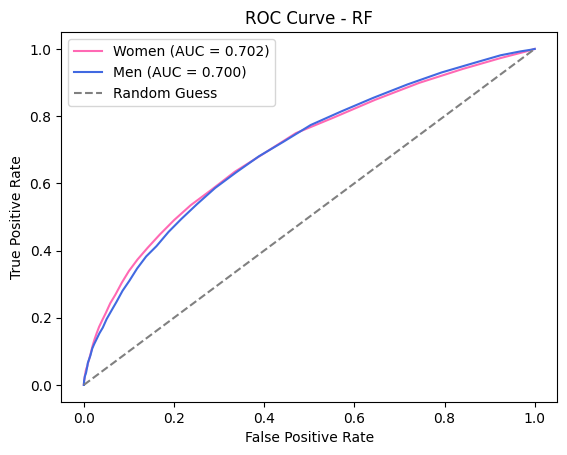

In [ ]:
fpr_f, tpr_f, _ = roc_curve(y_test_female, rf_pred_female)
fpr_m, tpr_m, _ = roc_curve(y_test_male, rf_pred_male)

# plot ROC curves
plt.plot(fpr_f, tpr_f, color='hotpink', label='Women (AUC = {:.3f})'.format(auc_female))
plt.plot(fpr_m, tpr_m, color='royalblue', label='Men (AUC = {:.3f})'.format(auc_male))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - RF')
plt.legend()
plt.show()

scores are very close, suggesting that the model has almost equal ability to discriminate between the positive and negative classes for both sex

In [ ]:
# mean error in predictions
errs_f = y_test_female - rf_pred_female
errs_m = y_test_male - rf_pred_male

mean_err_f = errs_f.mean()
mean_err_m = errs_m.mean()


print("Mean Error for Females:", mean_err_f)
print("Mean Error for Males:", mean_err_m)

Mean Error for Females: -0.010321603739425268
Mean Error for Males: -0.0045550087315446965


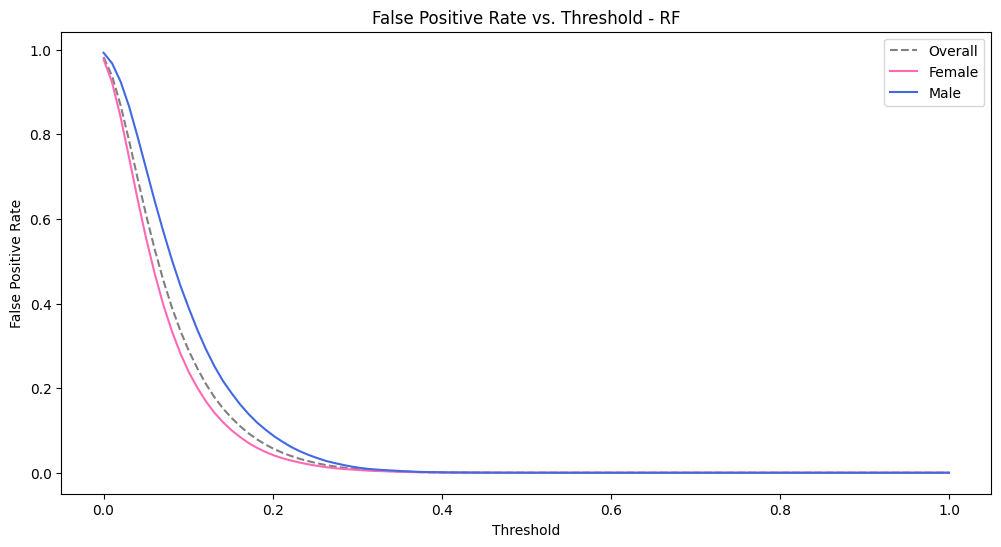

In [ ]:
# comparing FPR by sex
thresholds = np.linspace(0, 1, 100)
rf_fprs_overall = []
rf_fprs_female = []
rf_fprs_male = []

for threshold in thresholds:
    y_pred = predictions > threshold
    conf_matrix = confusion_matrix(app_train_y_test, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    fpr_overall = fp / (fp + tn)
    rf_fprs_overall.append(fpr_overall)

    subgroup_indices_female = app_train_x_test['CODE_GENDER_F'] == True
    subgroup_indices_male = app_train_x_test['CODE_GENDER_F'] == False

    conf_matrix_female = confusion_matrix(app_train_y_test[subgroup_indices_female], y_pred[subgroup_indices_female])
    tn_female, fp_female, fn_female, tp_female = conf_matrix_female.ravel()
    fpr_female = fp_female / (fp_female + tn_female)
    rf_fprs_female.append(fpr_female)

    conf_matrix_male = confusion_matrix(app_train_y_test[subgroup_indices_male], y_pred[subgroup_indices_male])
    tn_male, fp_male, fn_male, tp_male = conf_matrix_male.ravel()
    fpr_male = fp_male / (fp_male + tn_male)
    rf_fprs_male.append(fpr_male)

# fpr vs. threshold values
plt.figure(figsize=(12, 6))
plt.plot(thresholds, rf_fprs_overall, label='Overall', color='grey', linestyle='--')
plt.plot(thresholds, rf_fprs_female, label='Female', color='hotpink', linestyle='-')
plt.plot(thresholds, rf_fprs_male, label='Male', color='royalblue', linestyle='-')

plt.xlabel('Threshold')
plt.ylabel('False Positive Rate')
plt.title('False Positive Rate vs. Threshold - RF')
plt.legend()
plt.show()

Similar to with the logistic regression, we can see by going through the 100 possible thresholds that using this logistic regression model, the fpr is always lower for women than it is for men (when they arent equal no or all false positives). However, the divide between FPR for men and women seems more defined than in the logistic regression despite the random forest being chosen by the solution for its greater accuracy (determined by the AUC). As with the logistic regression, this might present a cause for concern in that men are seemingly more likely, by this model to be classified as unreliable for a loan incorrectly than women, but to an even greater degree as the disparity is greater.

###demographic and selection rate

In [ ]:
#compute demographic parity difference and demographic parity ratio for target=0, diff sex
cols = ['CODE_GENDER_F', 'CODE_GENDER_M']
sensitive_feats = app_train_x_test[cols]
negative_class_pred = 1 - predictions
demo_parity_diff = demographic_parity_difference(app_train_y_test, negative_class_pred, sensitive_features=sensitive_feats)
demo_parity_ratio = demographic_parity_ratio(app_train_y_test, negative_class_pred, sensitive_features=sensitive_feats)

print(f'Demographic parity difference: {demo_parity_diff:.4f}')
print(f'Demographic parity ratio: {demo_parity_ratio:.4f}')

sex_selection_rates = {}
for sex in cols:
  select_rate = selection_rate(app_train_y_test[app_train_x_test[sex]==True], negative_class_pred[app_train_x_test[sex]==True])
  sex_selection_rates[sex.split('_')[-1]] = round(select_rate, 4)
print('selection rates for each sex\n')
sex_selection_rates

Demographic parity difference: 0.0216
Demographic parity ratio: 0.0000
selection rates for each sex



{'F': 0.0216, 'M': 0.0066}

In [ ]:
sex_rf_selection = pd.DataFrame(list(sex_selection_rates.items()), columns=['Sex', 'Selection Rate (RF)'])
sex_rf_selection

,Sex,Selection Rate (RF)
0,F,0.0216
1,M,0.0066


## family status

###family status accuracy

AUC for NAME_FAMILY_STATUS_Civil marriage : 0.7164319705582645
AUC for NAME_FAMILY_STATUS_Married : 0.7069346845546297
AUC for NAME_FAMILY_STATUS_Separated : 0.7174612349763796
AUC for NAME_FAMILY_STATUS_Single / not married : 0.7011645121439037
AUC for NAME_FAMILY_STATUS_Widow : 0.6422684779433246


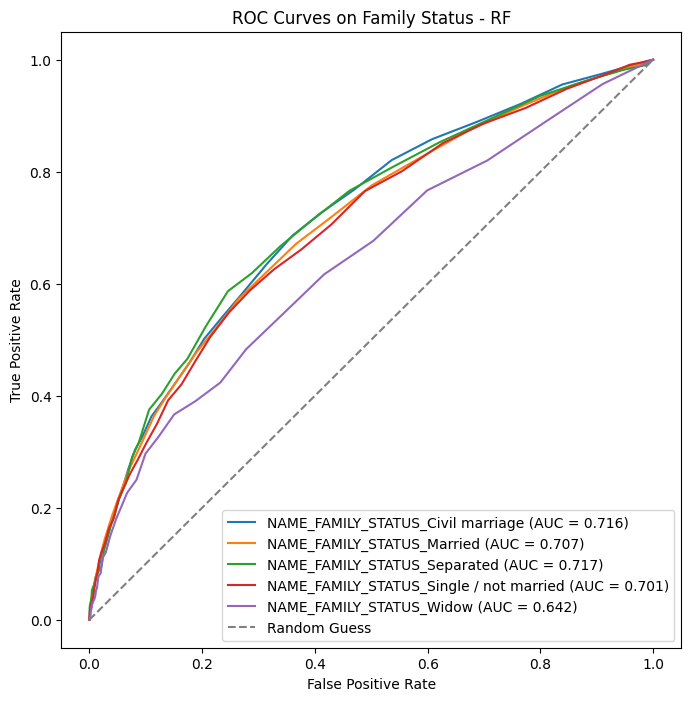

In [ ]:
cols = ['NAME_FAMILY_STATUS_Civil marriage', 'NAME_FAMILY_STATUS_Married',
        'NAME_FAMILY_STATUS_Separated', 'NAME_FAMILY_STATUS_Single / not married',
        'NAME_FAMILY_STATUS_Widow']

auc_scores = []
plt.figure(figsize=(8,8))
for column in cols:
    x_test_subgroup = app_train_x_test[app_train_x_test[column] == True]
    y_test_subgroup = app_train_y_test[app_train_x_test[column] == True]
    rf_pred_subgroup = predictions[app_train_x_test[column] == True]

    # AUC
    auc_subgroup = roc_auc_score(y_test_subgroup, rf_pred_subgroup)
    auc_scores.append(auc_subgroup)
    print("AUC for", column, ":", auc_subgroup)

    # ROC
    fpr, tpr, _ = roc_curve(y_test_subgroup, rf_pred_subgroup)
    plt.plot(fpr, tpr, label=f'{column} (AUC = {auc_subgroup:.3f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves on Family Status - RF')
plt.legend()
plt.show()

###demographic parity and selection rate for family status

In [ ]:
#compute demographic parity difference and demographic parity ratio for target=0, diff fam status
cols = ['NAME_FAMILY_STATUS_Civil marriage', 'NAME_FAMILY_STATUS_Married',
        'NAME_FAMILY_STATUS_Separated', 'NAME_FAMILY_STATUS_Single / not married',
        'NAME_FAMILY_STATUS_Widow']
sensitive_feats = app_train_x_test[cols]
negative_class_pred = 1 - predictions
demo_parity_diff = demographic_parity_difference(app_train_y_test, negative_class_pred, sensitive_features=sensitive_feats)
demo_parity_ratio = demographic_parity_ratio(app_train_y_test, negative_class_pred, sensitive_features=sensitive_feats)

print(f'Demographic parity difference: {demo_parity_diff:.4f}')
print(f'Demographic parity ratio: {demo_parity_ratio:.10f}')

fam_selection_rates = {}
for fam in cols:
  select_rate = selection_rate(app_train_y_test[app_train_x_test[fam]==True], negative_class_pred[app_train_x_test[fam]==True])
  fam_selection_rates[fam.split('_')[-1]] = round(select_rate, 4)
print('selection rates for each family status\n')
fam_selection_rates

Demographic parity difference: 0.0170
Demographic parity ratio: 0.3640001575
selection rates for each family status



{'Civil marriage': 0.0103,
 'Married': 0.0183,
 'Separated': 0.0146,
 'Single / not married': 0.0097,
 'Widow': 0.0267}

In [ ]:
fam_rf_selection = pd.DataFrame(list(fam_selection_rates.items()), columns=['Family Status', 'Selection Rate (RF)'])
fam_rf_selection

,Family Status,Selection Rate (RF)
0,Civil marriage,0.0103
1,Married,0.0183
2,Separated,0.0146
3,Single / not married,0.0097
4,Widow,0.0267


## occupation analysis

###occupation accuracy

AUC for Accountants : 0.704195962337075
AUC for Cleaning staff : 0.6691750890039988
AUC for Cooking staff : 0.7026370498304868
AUC for Core staff : 0.730154489869745
AUC for Drivers : 0.6778183991437327
AUC for HR staff : 0.9051383399209486
AUC for High skill tech staff : 0.676429153168661
AUC for IT staff : 0.7972222222222223
AUC for Laborers : 0.7071490906564243
AUC for Low-skill Laborers : 0.648319050758075
AUC for Managers : 0.7191984567599189
AUC for Medicine staff : 0.7181384684805542
AUC for Private service staff : 0.7258725071225071
AUC for Realty agents : 0.6593094405594406
AUC for Sales staff : 0.6829736660807058
AUC for Secretaries : 0.629788306451613
AUC for Security staff : 0.6815960178982764


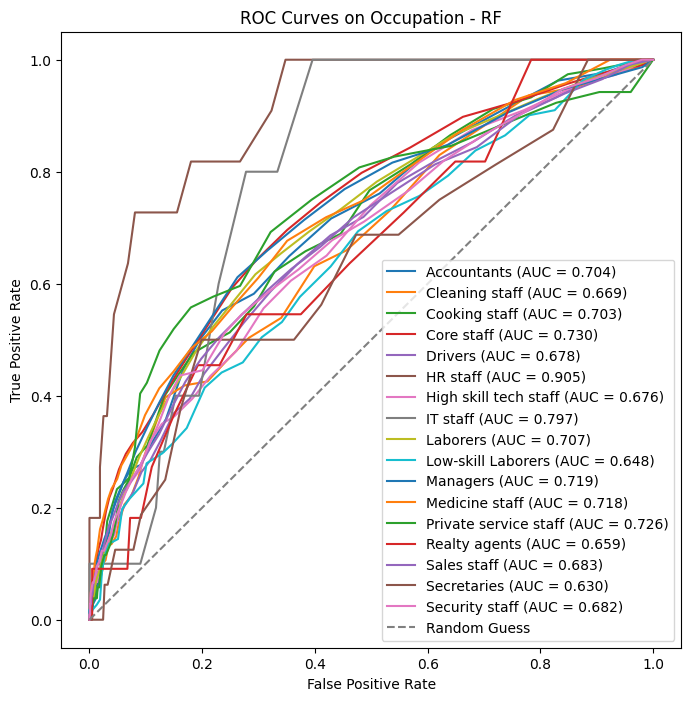

In [ ]:
cols = ['OCCUPATION_TYPE_Accountants', 'OCCUPATION_TYPE_Cleaning staff',
        'OCCUPATION_TYPE_Cooking staff', 'OCCUPATION_TYPE_Core staff',
        'OCCUPATION_TYPE_Drivers', 'OCCUPATION_TYPE_HR staff',
        'OCCUPATION_TYPE_High skill tech staff', 'OCCUPATION_TYPE_IT staff',
        'OCCUPATION_TYPE_Laborers', 'OCCUPATION_TYPE_Low-skill Laborers',
        'OCCUPATION_TYPE_Managers', 'OCCUPATION_TYPE_Medicine staff',
        'OCCUPATION_TYPE_Private service staff', 'OCCUPATION_TYPE_Realty agents',
        'OCCUPATION_TYPE_Sales staff', 'OCCUPATION_TYPE_Secretaries', 'OCCUPATION_TYPE_Security staff']

auc_scores = []
plt.figure(figsize=(8,8))
for column in cols:
    name = column[16:]
    x_test_subgroup = app_train_x_test[app_train_x_test[column] == True]
    y_test_subgroup = app_train_y_test[app_train_x_test[column] == True]
    rf_pred_subgroup = predictions[app_train_x_test[column] == True]

    # AUC
    auc_subgroup = roc_auc_score(y_test_subgroup, rf_pred_subgroup)
    auc_scores.append(auc_subgroup)
    print("AUC for", name, ":", auc_subgroup)

    # ROC
    fpr, tpr, _ = roc_curve(y_test_subgroup, rf_pred_subgroup)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_subgroup:.3f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves on Occupation - RF')
plt.legend()
plt.show()

AUC for INCOME >= 60,000: 0.7092244525964095
AUC for INCOME < 60,000: 0.6575919216317767


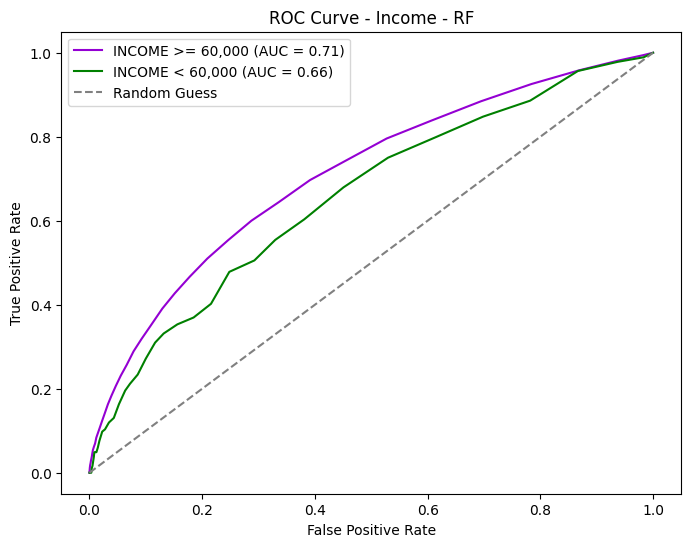

In [ ]:
# threshold for dividing income
threshold = 60000

# AUC for INCOME >= 50000
x_test_income_greater = app_train_x_test[app_train_x_test['AMT_INCOME_TOTAL'] >= threshold]
y_test_income_greater = app_train_y_test[app_train_x_test['AMT_INCOME_TOTAL'] >= threshold]
predictions_income_greater = predictions[app_train_x_test['AMT_INCOME_TOTAL'] >= threshold]
auc_income_greater = roc_auc_score(y_test_income_greater, predictions_income_greater)
print("AUC for INCOME >= 60,000:", auc_income_greater)

# AUC for INCOME < 50000
x_test_income_less = app_train_x_test[app_train_x_test['AMT_INCOME_TOTAL'] < threshold]
y_test_income_less = app_train_y_test[app_train_x_test['AMT_INCOME_TOTAL'] < threshold]
predictions_income_less = predictions[app_train_x_test['AMT_INCOME_TOTAL'] < threshold]
auc_income_less = roc_auc_score(y_test_income_less, predictions_income_less)
print("AUC for INCOME < 60,000:", auc_income_less)

fpr_income_greater, tpr_income_greater, _ = roc_curve(y_test_income_greater, predictions_income_greater)
fpr_income_less, tpr_income_less, _ = roc_curve(y_test_income_less, predictions_income_less)

# ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_income_greater, tpr_income_greater, color='darkviolet', label='INCOME >= 60,000 (AUC = {:.2f})'.format(auc_income_greater))
plt.plot(fpr_income_less, tpr_income_less, color='g', label='INCOME < 60,000 (AUC = {:.2f})'.format(auc_income_less))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Income - RF')
plt.legend()
plt.show()

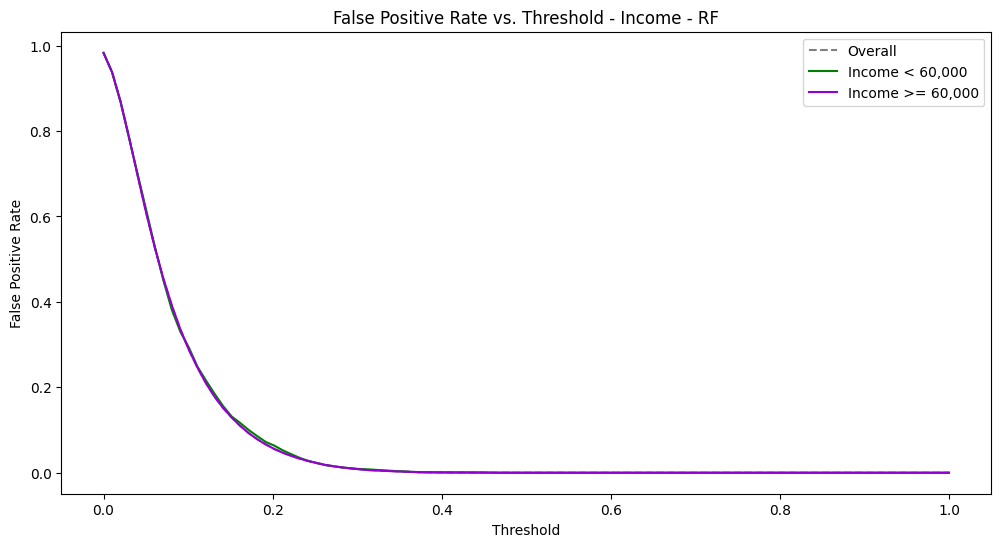

In [ ]:
# comparing FPR by income
thresholds = np.linspace(0, 1, 100)
rf_fprs_overall = []
rf_fprs_less = []
rf_fprs_greater = []

for threshold in thresholds:
    y_pred = predictions > threshold
    conf_matrix = confusion_matrix(app_train_y_test, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    fpr_overall = fp / (fp + tn)
    rf_fprs_overall.append(fpr_overall)

    subgroup_indices_less = app_train_x_test['AMT_INCOME_TOTAL'] < 60000
    subgroup_indices_greater = app_train_x_test['AMT_INCOME_TOTAL'] >= 60000

    conf_matrix_less = confusion_matrix(app_train_y_test[subgroup_indices_less], y_pred[subgroup_indices_less])
    tn_less, fp_less, fn_less, tp_less = conf_matrix_less.ravel()
    fpr_less = fp_less / (fp_less + tn_less)
    rf_fprs_less.append(fpr_less)

    conf_matrix_greater = confusion_matrix(app_train_y_test[subgroup_indices_greater], y_pred[subgroup_indices_greater])
    tn_greater, fp_greater, fn_greater, tp_greater = conf_matrix_greater.ravel()
    fpr_greater = fp_greater / (fp_greater + tn_greater)
    rf_fprs_greater.append(fpr_greater)

# fpr vs. threshold values
plt.figure(figsize=(12, 6))
plt.plot(thresholds, rf_fprs_overall, label='Overall', color='grey', linestyle='--')
plt.plot(thresholds, rf_fprs_less, label='Income < 60,000', color='g', linestyle='-')
plt.plot(thresholds, rf_fprs_greater, label='Income >= 60,000', color='darkviolet', linestyle='-')

plt.xlabel('Threshold')
plt.ylabel('False Positive Rate')
plt.title('False Positive Rate vs. Threshold - Income - RF')
plt.legend()
plt.show()

###occupation demographic parity and selection rate

In [ ]:
#compute demographic parity difference and demographic parity ratio for target=0, diff occupation
cols = ['OCCUPATION_TYPE_Accountants', 'OCCUPATION_TYPE_Cleaning staff',
        'OCCUPATION_TYPE_Cooking staff', 'OCCUPATION_TYPE_Core staff',
        'OCCUPATION_TYPE_Drivers', 'OCCUPATION_TYPE_HR staff',
        'OCCUPATION_TYPE_High skill tech staff', 'OCCUPATION_TYPE_IT staff',
        'OCCUPATION_TYPE_Laborers', 'OCCUPATION_TYPE_Low-skill Laborers',
        'OCCUPATION_TYPE_Managers', 'OCCUPATION_TYPE_Medicine staff',
        'OCCUPATION_TYPE_Private service staff', 'OCCUPATION_TYPE_Realty agents',
        'OCCUPATION_TYPE_Sales staff', 'OCCUPATION_TYPE_Secretaries', 'OCCUPATION_TYPE_Security staff']
sensitive_feats = app_train_x_test[cols]
negative_class_pred = 1 - predictions
demo_parity_diff = demographic_parity_difference(app_train_y_test, negative_class_pred, sensitive_features=sensitive_feats)
demo_parity_ratio = demographic_parity_ratio(app_train_y_test, negative_class_pred, sensitive_features=sensitive_feats)

print(f'Demographic parity difference: {demo_parity_diff:.4f}')
print(f'Demographic parity ratio: {demo_parity_ratio:.4f}')

job_selection_rates = {}
for occupation in cols:
  select_rate = selection_rate(app_train_y_test[app_train_x_test[occupation]==True], negative_class_pred[app_train_x_test[occupation]==True])
  job_selection_rates[occupation.split('_')[-1]] = round(select_rate, 4)
print('selection rates for each occupation\n')
job_selection_rates

Demographic parity difference: 0.0349
Demographic parity ratio: 0.0000
selection rates for each occupation



{'Accountants': 0.0211,
 'Cleaning staff': 0.0071,
 'Cooking staff': 0.0072,
 'Core staff': 0.0182,
 'Drivers': 0.0038,
 'HR staff': 0.0349,
 'High skill tech staff': 0.0184,
 'IT staff': 0.013,
 'Laborers': 0.0059,
 'Low-skill Laborers': 0.0,
 'Managers': 0.0186,
 'Medicine staff': 0.0191,
 'Private service staff': 0.0136,
 'Realty agents': 0.0,
 'Sales staff': 0.0096,
 'Secretaries': 0.0129,
 'Security staff': 0.0025}

In [ ]:
job_rf_selection = pd.DataFrame(list(job_selection_rates.items()), columns=['Occupation Type', 'Selection Rate (RF)'])
job_rf_selection

,Occupation Type,Selection Rate (RF)
0,Accountants,0.0211
1,Cleaning staff,0.0071
2,Cooking staff,0.0072
3,Core staff,0.0182
4,Drivers,0.0038
5,HR staff,0.0349
6,High skill tech staff,0.0184
7,IT staff,0.0130
8,Laborers,0.0059
9,Low-skill Laborers,0.0000


##age analysis

AUC for AGE >= 50: 0.6717489826783961
AUC for AGE < 50: 0.7088576262559252


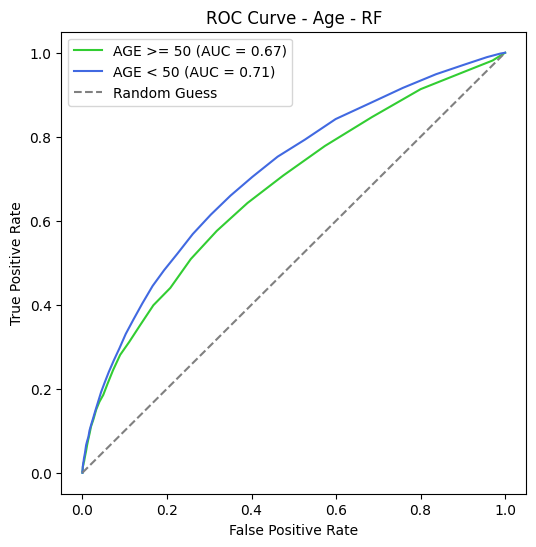

In [ ]:
app_train_x_test['AGE'] = np.abs(app_train_x_test['DAYS_BIRTH'] / 365)

# threshold for dividing age
threshold = 50

# AUC for AGE >= 50
rf_pred_age_greater_than_50 = predictions[app_train_x_test['AGE'] >= threshold]
auc_age_greater_than_50 = roc_auc_score(y_test_age_greater_than_50, rf_pred_age_greater_than_50)
print("AUC for AGE >= 50:", auc_age_greater_than_50)

# AUC for AGE < 50
rf_pred_age_less_than_50 = predictions[app_train_x_test['AGE'] < threshold]
auc_age_less_than_50 = roc_auc_score(y_test_age_less_than_50, rf_pred_age_less_than_50)
print("AUC for AGE < 50:", auc_age_less_than_50)

fpr_age_greater_than_50, tpr_age_greater_than_50, _ = roc_curve(y_test_age_greater_than_50, rf_pred_age_greater_than_50)
fpr_age_less_than_50, tpr_age_less_than_50, _ = roc_curve(y_test_age_less_than_50, rf_pred_age_less_than_50)

# ROC curves
plt.figure(figsize=(6, 6))
plt.plot(fpr_age_greater_than_50, tpr_age_greater_than_50, color='limegreen', label='AGE >= 50 (AUC = {:.2f})'.format(auc_age_greater_than_50))
plt.plot(fpr_age_less_than_50, tpr_age_less_than_50, color='royalblue', label='AGE < 50 (AUC = {:.2f})'.format(auc_age_less_than_50))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Age - RF')
plt.legend()
plt.show()

In [ ]:
# mean error in predictions
errs_y = y_test_age_less_than_50 - rf_pred_age_less_than_50
errs_o = y_test_age_greater_than_50 - rf_pred_age_greater_than_50

mean_err_y = errs_y.mean()
mean_err_o = errs_o.mean()

print("Mean Error for Age < 50 :", mean_err_y)
print("Mean Error for Age >= 50:", mean_err_o)

Mean Error for Age < 50 : -0.007733503035049939
Mean Error for Age >= 50: -0.009587988375847602


AUC for Quantile 1 : 0.6953513452564468
AUC for Quantile 2 : 0.7116550247249229
AUC for Quantile 3 : 0.701920369933791
AUC for Quantile 4 : 0.6596964340314583


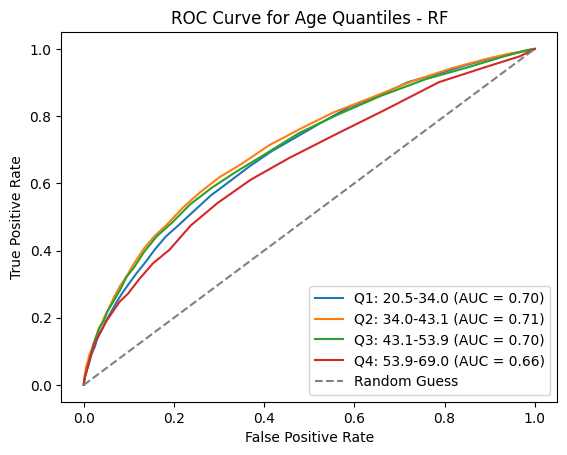

In [ ]:
# divide data into four quantiles of unique ages
app_train_x_test['AGE'] = np.abs(app_train_x_test['DAYS_BIRTH'] / 365)
quantiles = pd.qcut(app_train_x_test['AGE'], q=4, labels=False)

# calculate AUC and ROC curves for each quantile
auc_scores = []
for quantile in range(4):
    x_test_quantile = app_train_x_test[quantiles == quantile]
    y_test_quantile = app_train_y_test[quantiles == quantile]
    rf_pred_quantile = predictions[quantiles == quantile]

    age_min = min(x_test_quantile['AGE'])
    age_max = max(x_test_quantile['AGE'])

    # AUC
    auc_quantile = roc_auc_score(y_test_quantile, rf_pred_quantile)
    auc_scores.append(auc_quantile)
    print("AUC for Quantile", quantile + 1, ":", auc_quantile)

    # ROC
    fpr, tpr, _ = roc_curve(y_test_quantile, rf_pred_quantile)
    plt.plot(fpr, tpr, label=f'Q{quantile + 1}: {age_min:.1f}-{age_max:.1f} (AUC = {auc_quantile:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Age Quantiles - RF')
plt.legend()
plt.show()

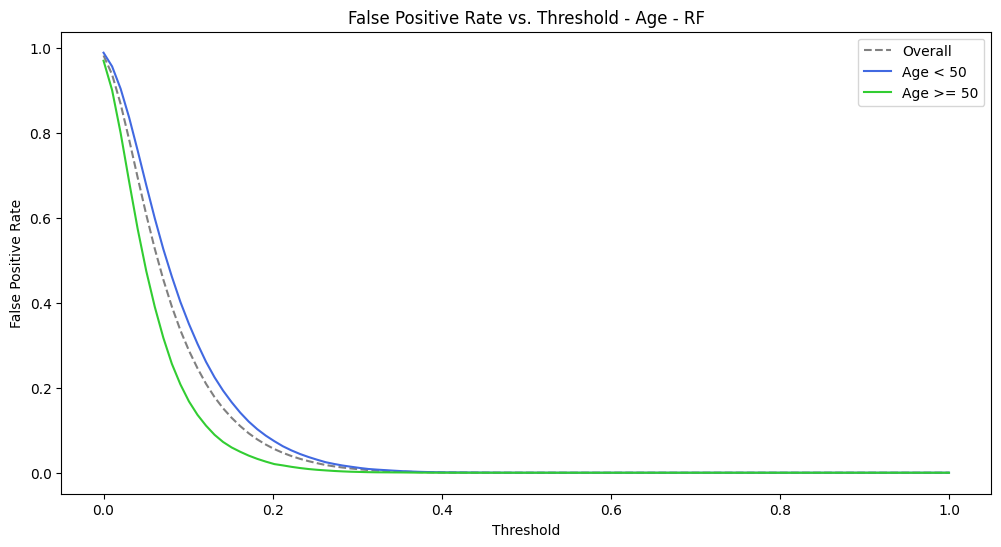

In [ ]:
# comparing FPR by age
thresholds = np.linspace(0, 1, 100)
rf_fprs_overall = []
rf_fprs_less = []
rf_fprs_greater = []

for threshold in thresholds:
    y_pred = predictions > threshold
    conf_matrix = confusion_matrix(app_train_y_test, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    fpr_overall = fp / (fp + tn)
    rf_fprs_overall.append(fpr_overall)

    subgroup_indices_less = app_train_x_test['AGE'] < 50
    subgroup_indices_greater = app_train_x_test['AGE'] >= 50

    conf_matrix_less = confusion_matrix(app_train_y_test[subgroup_indices_less], y_pred[subgroup_indices_less])
    tn_less, fp_less, fn_less, tp_less = conf_matrix_less.ravel()
    fpr_less = fp_less / (fp_less + tn_less)
    rf_fprs_less.append(fpr_less)

    conf_matrix_greater = confusion_matrix(app_train_y_test[subgroup_indices_greater], y_pred[subgroup_indices_greater])
    tn_greater, fp_greater, fn_greater, tp_greater = conf_matrix_greater.ravel()
    fpr_greater = fp_greater / (fp_greater + tn_greater)
    rf_fprs_greater.append(fpr_greater)

# fpr vs. threshold values
plt.figure(figsize=(12, 6))
plt.plot(thresholds, rf_fprs_overall, label='Overall', color='grey', linestyle='--')
plt.plot(thresholds, rf_fprs_less, label='Age < 50', color='royalblue', linestyle='-')
plt.plot(thresholds, rf_fprs_greater, label='Age >= 50', color='limegreen', linestyle='-')

plt.xlabel('Threshold')
plt.ylabel('False Positive Rate')
plt.title('False Positive Rate vs. Threshold - Age - RF')
plt.legend()
plt.show()

## overall

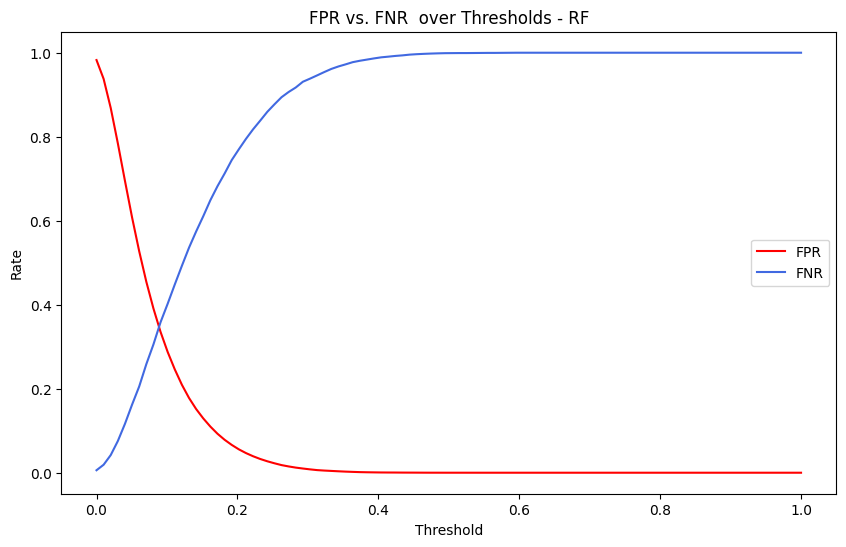

In [ ]:
thresholds = np.linspace(0, 1, 100)
fprs = []
fnrs = []

for threshold in thresholds:
    y_pred = predictions > threshold
    tn, fp, fn, tp = confusion_matrix(app_train_y_test, y_pred).ravel()
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)
    fprs.append(fpr)
    fnrs.append(fnr)

# fpr vs. fnr over threshold values
plt.figure(figsize=(10, 6))
plt.plot(thresholds, fprs, label='FPR', color='red', linestyle='-')
plt.plot(thresholds, fnrs, label='FNR', color='royalblue', linestyle='-')
plt.xlabel('Threshold')
plt.ylabel('Rate')
plt.title('FPR vs. FNR  over Thresholds - RF')
plt.legend()
plt.show()

#Shap

In [ ]:
# feature importances
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

#since we have feature importance for the rf model we'll select top 5 for explainability
sorted_feature_importances = feature_importances.sort_values(by='importance', ascending=False)
top_5_feats = sorted_feature_importances.head(5)
top_5_feats_list = top_5_feats['feature'].tolist()
top_5_feats_list

['EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'DAYS_ID_PUBLISH',
 'DAYS_REGISTRATION']

In [ ]:
#for explainability and shorten runtime we take a subset from test set
X_train_im_feats = app_train_x_train[top_5_feats_list]
X_test_im_feats = app_train_x_test[top_5_feats_list]

subset_X_test = X_test_im_feats.sample(frac=0.01, random_state=42)

In [ ]:
# Initialize the explainer on rf model
explainer = shap.TreeExplainer(random_forest, X_train_im_feats, feature_perturbation="interventional")

# Apply it to the subset test data
shap_values = float(explainer.shap_values(subset_X_test))

In [ ]:
# Initialize the explainer
explainer = shap.LinearExplainer(log_reg, train, feature_perturbation="interventional")
# Apply it to the test data
shap_values = explainer.shap_values(test)

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


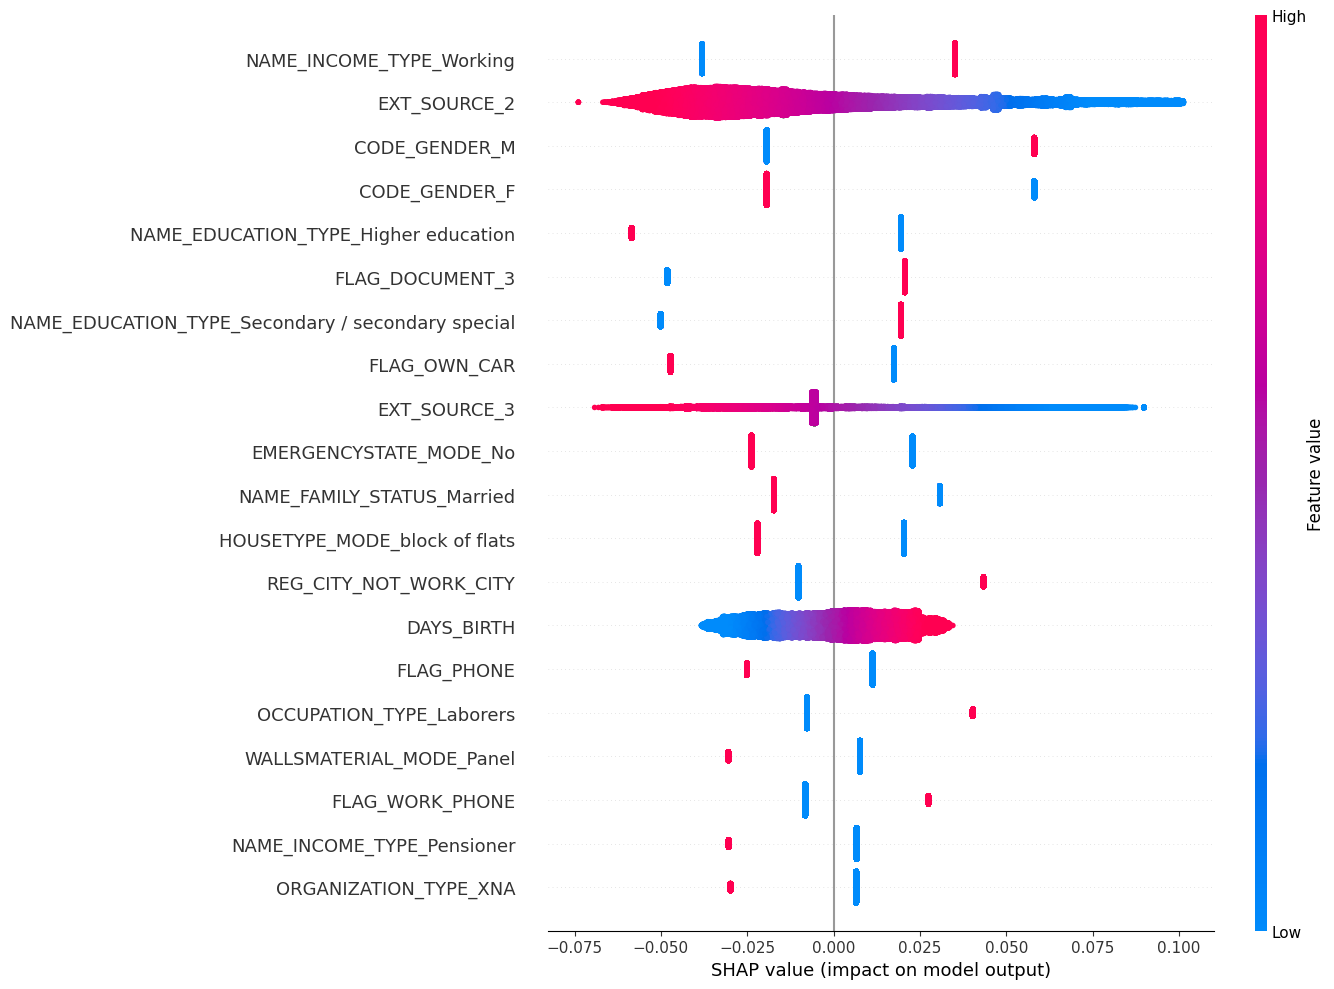

In [ ]:
shap.summary_plot(shap_values, app_train_x_test, feature_names=app_train_x_train.columns, plot_size=[14,10])

Of the models used in this solution, two of them are random forests, which have the con of being not linear, which makes them incompatible with many methods of explainability due to the complexity of tracking how a feature impacts the outcome through multiple decision trees. There are methods of creating enhanced random forest algorithms that aim to improve interpretability, but these were not used in this solution. However, one of the solution's models, the logistic regression model, is more easily compatible with explainability methods like SHAP, the output of which is displayed above in the SHAP summary plot.

Despite the random forest model's incompatibility with the SHAP analysis done for the logistic regression model, we can still extract some primative feature importances, which are displayed above and rank in decending importance from 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'DAYS_ID_PUBLISH', 'DAYS_REGISTRATION', which we can see bears some similarity to the important features in the logistic regression, as seen in the summary plot with 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', et cetera.

#selection rates across models into tables

In [ ]:
#based on sex
sex_lg_selection.set_index('Sex', inplace=True)
sex_rf_selection.set_index('Sex', inplace=True)

#concatenate them along axis=1 (columns)
sex_selection = pd.concat([sex_lg_selection, sex_rf_selection], axis=1)
sex_selection

,Selection Rate (Log Reg Baseline),Selection Rate (RF)
Sex,,
F,0.0,0.0216
M,0.0,0.0066


In [ ]:
#based on fam status
fam_lg_selection.set_index('Family Status', inplace=True)
fam_rf_selection.set_index('Family Status', inplace=True)

fam_selection = pd.concat([fam_lg_selection, fam_rf_selection], axis=1)
fam_selection

,Selection Rate (Log Reg Baseline),Selection Rate (RF)
Family Status,,
Civil marriage,0.0,0.0103
Married,0.0,0.0183
Separated,0.0,0.0146
Single / not married,0.0,0.0097
Widow,0.0,0.0267


In [ ]:
#based on occupation
job_lg_selection.set_index('Occupation Type', inplace=True)
job_rf_selection.set_index('Occupation Type', inplace=True)

job_selection = pd.concat([job_lg_selection, job_rf_selection], axis=1)
job_selection

,Selection Rate (Log Reg Baseline),Selection Rate (RF)
Occupation Type,,
Accountants,0.0,0.0211
Cleaning staff,0.0,0.0071
Cooking staff,0.0,0.0072
Core staff,0.0,0.0182
Drivers,0.0,0.0038
HR staff,0.0,0.0349
High skill tech staff,0.0,0.0184
IT staff,0.0,0.0130
Laborers,0.0,0.0059
